# `PartitionShap`: tornado prediction (4-band) channel-wise demo

**Purpose:** This notebook compares the default implementation of `PartitionShap` to [CBI's fork](https://github.com/conrad-blucher-institute/shap) that implement's channel-wise explanations. 
That is, the default paritions images by splitting the rows and columns. Only at the pixel-level does it split across the channels/bands. For 3D inputs, it may be of interest to explain the contribution of bands on superpixel regions. 
The fork introduces the option to split first by channels, then by superpixels. 

**Data:**
from [Machine Learning in Python for Environmental Science Problems AMS Short Course Material](https://github.com/djgagne/ams-ml-python-course) by David John Gagne

**Notebook based on:**
Ryan Lagerquist's [AI2ES/CIRA short course on XAI for Environmental science](https://docs.google.com/document/d/1lqpABwDl3kPe6ThE-NIDR64PimnltJEuKNkysDZuWKQ/edit)

  - Lecture 3 performs XAI on same model, data using other techniques
  - Much of the code below is adapted from the [Lecture 3 notebook](https://colab.research.google.com/drive/1s0V0uTZrsHoEzmnGcvGM_MeX2NbPOI2U?authuser=1) to compare XAI results

## Task & data description

**Goal:** 
- Given: 
  - simulated radar reflectivity > 40 dBZ
  - associated surface wind & temperature fields
- Predict: probability of low-level vorticity exceeding a certain threshold 

**Input feature maps (raster channels):**

- `REFL_COM_curr` (composite reflectivity)
- `U10_curr` (10 m west-east wind component in m/s)
- `V10_curr` (10 m south-north wind component in m/s)
- `T2_curr` (2 m temperature in Kelvin)

**Prediction target:**

- `RVORT1_MAX_future` (hourly maximum vertical vorticity at 1 km Above ground level in s-1)




## Setup environment

**File paths**

In [ ]:
# Pre-trained model 
cnn_file_name = '/content/course_repository/pretrained_cnn/model.h5'

# Data 
LOCAL_DIRECTORY_NAME = 'data'
ONLINE_IMAGE_FILE_NAME = (
    'https://storage.googleapis.com/track_data_ncar_ams_3km_nc_small/'
    'track_data_ncar_ams_3km_nc_small.tar.gz'
)

**Install packages**

In [ ]:
import os 
import sys
import shutil

# Install non-colab default packages
!pip install cartopy

# Install CBI's SHAP fork
!pip install git+https://github.com/conrad-blucher-institute/shap.git

# Install Ryan Lagerquist's AI2ES short course repo
#   Contains various helper packages
# Remove if already cloned
if os.path.isdir('course_repository'):
    shutil.rmtree('course_repository')
# Clone
!git clone https://github.com/thunderhoser/ai2es_xai_course course_repository
# Install
!cd course_repository; python setup.py install

In [ ]:
# Add directories to python path
sys.path.append('/content/data/')
sys.path.append('/content/course_repository/')
sys.path.append('/content/course_repository/ai2es_xai_course/')
sys.path.append('/content/course_repository/ai2es_xai_course/utils/')

In [ ]:
# General packages
import os
import sys
import shutil
import errno
import tarfile
import time
import copy
import glob
import os.path
import numpy as np
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import percentileofscore
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# CBI's shap fork
import shap

# Packages from Ryan Lagerquist's AI2ES short course repo
from ai2es_xai_course.plotting import image_plotting, feature_map_plotting
from ai2es_xai_course.utils import utils, image_utils, image_normalization, \
    image_thresholding, cnn, saliency, class_activation, occlusion

**Define constants**

Most of the following are keys to access variables in storm object data structures.

There are 2 major data structures: 

- netCDF originals
- derived dictionaries with only a relevant subset

The dictionaries are given more descriptive names for the variables,
so the following has, for example, `U_WIND_NAME` storing the key for the dictionary, 
and `U_WIND_NAME_ORIG` containing the key to access the same data in the netCDF.

In [ ]:
# Date formats
DATE_FORMAT = '%Y%m%d'
DATE_FORMAT_REGEX = '[0-9][0-9][0-9][0-9][0-1][0-9][0-3][0-9]'

# Predictor names
REFLECTIVITY_NAME = 'reflectivity_dbz'
TEMPERATURE_NAME = 'temperature_kelvins'
U_WIND_NAME = 'u_wind_m_s01'
V_WIND_NAME = 'v_wind_m_s01'
# Target name
TARGET_NAME = 'max_future_vorticity_s01'

PREDICTOR_NAMES = [
    REFLECTIVITY_NAME, TEMPERATURE_NAME, U_WIND_NAME, V_WIND_NAME
]

# Mapping between dictionary names (new) and netCDF names (original)
PREDICTOR_NAME_TO_ORIG = {
    REFLECTIVITY_NAME: 'REFL_COM_curr',
    TEMPERATURE_NAME: 'T2_curr',
    U_WIND_NAME: 'U10_curr',
    V_WIND_NAME: 'V10_curr'
}

# Other netCDF names
STORM_ID_NAME_ORIG = 'track_id'
STORM_STEP_NAME_ORIG = 'track_step'
TARGET_NAME_ORIG = 'RVORT1_MAX_future'

# Keys
STORM_IDS_KEY = 'storm_id_nums'
STORM_STEPS_KEY = 'storm_steps'
PREDICTOR_NAMES_KEY = 'predictor_names'
PREDICTOR_MATRIX_KEY = 'predictor_matrix'
TARGET_NAME_KEY = 'target_name'
TARGET_MATRIX_KEY = 'target_matrix'

## Load data & model

### Load pre-trained CNN

In [ ]:
cnn_model_object = utils.read_dense_net(cnn_file_name)
cnn_model_object.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 4)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        1184      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
________________________________________________

### Download data

In [ ]:
# Make directory for storm data
try:
  os.makedirs(LOCAL_DIRECTORY_NAME)
except:
  pass

# Download storm data
t0 = time.time()
local_image_file_name = '{0:s}/{1:s}'.format(
        LOCAL_DIRECTORY_NAME, os.path.split(ONLINE_IMAGE_FILE_NAME)[-1]
    )
print('Downloading data to: "{0:s}"...'.format(local_image_file_name))
urlretrieve(ONLINE_IMAGE_FILE_NAME, local_image_file_name)
print('Unzipping file: "{0:s}"...'.format(local_image_file_name))
tar_file_handle = tarfile.open(local_image_file_name)
tar_file_handle.extractall(LOCAL_DIRECTORY_NAME)
tar_file_handle.close()
print("Downloaded and unzipped in {} seconds".format(time.time() - t0))

Unzipping file: "data/track_data_ncar_ams_3km_nc_small.tar.gz"...
Downloaded and unzipped in 79.48711633682251 seconds


**Extreme cases**

Ryan Lagerquist's [Lecture 3 notebook](https://docs.google.com/document/d/1lqpABwDl3kPe6ThE-NIDR64PimnltJEuKNkysDZuWKQ/edit) extracts 4 types of extreme cases from the testing data. Instead of repeating those (several) code cells in this notebook, I printed them in Ryan's and saved the results here. 

Extreme case definitions (copied from Lagerquist's notebook)

- **Best hits:** the 100 positive examples with highest forecast probability
- **Worst false alarms:** the 100 negative examples with highest forecast probability
- **Worst misses:** the 100 positive examples with lowest forecast probability
- **Best correct nulls:** the 100 negative examples with lowest forecast probability

In [ ]:
best_hit_indices = np.array([ \
       10451, 13350,  5749, 14659, 13250,  2687,  6845,  6846,  6847,
        6848, 10642, 10643,  2731, 15811,  2767,  7080, 14515,  7121,
        7122,  9649,  7151,  7153, 10690, 14457,  9533,  4107,  3179,
       16315, 14660, 13363,  2806, 10449, 10450, 13614,  5912, 13552,
        5911,  2600, 10644,  2603,  7035,  6844, 16381, 13351,  6927,
        2601, 13362,  6774, 10689,  3748, 15912,  7152, 16215,  2114,
        5910, 10631,  9650,  5985, 14456,  6792,  5686,  7081, 13132,
       16635, 13853, 18571, 13615, 10636,  5729, 16402, 16278,  3668,
       10831,  8567, 13755, 16314, 15456,  2686, 14451,  6026, 13352,
       14720, 13551, 17340,  7092, 16534, 17337,  3728, 15813,  8508,
       19137, 10633, 15419, 13805, 19104, 13987,  3665,  2818, 13459,
       13252])

worst_false_alarm_indices = np.array([ \
        6356, 13798,  6389,  6125,  5721, 14518,  6914, 15991, 18755,
        5568,  9436,  1892, 11716,  6851, 13802, 13468,  5638, 12719,
       13831, 13370, 15542, 15681,  3188, 13457, 12909, 16284,  9788,
        8477, 15919, 12479,  6514,  9331, 13361, 12218,  6294, 17583,
        6917, 14880, 13470, 17606,  5623, 16436,  6837, 10003,  6417,
        1870,  4011, 17453,  5915,  3672,  1118,  7156, 12705, 12794,
        8752,  3662,  6128,  9951,  6852,  6459,  8753, 15994, 15772,
       12436,  6033, 10021,  9437, 13675, 16517, 18968,  6234,  8576,
        6438,  2553,  5794, 12475, 18254, 15986,  5625,  6554, 10577,
       13157,  3332, 17557, 17830, 12105,  2103,  8393, 13193, 13366,
       15771, 10037, 17604,  9948,  3240,  1620,  5703, 12480, 15775,
        8478])


worst_miss_indices = np.array([
       18112,  8894, 17333,  8671, 12419,   468,  5235,   831,  7998,
       18108,   671,  1568,   328,   529, 14525, 17511, 17513, 17209,
        5011, 17378,   536, 10379, 16604, 17474, 11988,  2355,   602,
        1650, 14770, 18991, 10539,  2177, 19151,   454,   537,  1331,
        2983, 16420, 10168,  2427, 13835, 16301,   266,  8927,  8929,
       15863, 17512,   530, 17510, 19109, 17326,  2321,   654,  7091,
       17475,  4971,   311,   323,   600,  5664, 18789, 18066, 13852,
       14593, 15365,  6397,  5195,  2426,   907,  3590,   772, 16121,
       15567,  6314, 10543,   333,   383,  2982,  3802, 17288,  8672,
        2314, 16374,   460,  2852, 13632,  8953, 15583, 10785,  2210,
       14839, 15363,  2311,   911,   898, 17588, 19305,  5436, 10431,
       10751])

best_correct_null_indices = np.array([
       17862, 17755, 18009, 18006, 17914, 16781, 17874, 15880, 16820,
         589, 16780, 18080,  2608, 18008, 18003, 15703, 17839, 18000,
       17829, 17857, 18219, 17957,  2811, 15881, 18004, 16737, 16302,
       18007,  1761,  3255, 16104,   588, 17860, 15753,  1477, 16305,
        2666, 16742,  3224,  1286, 17861, 17999, 16805, 18115,  2438,
       18184, 17724, 15761, 19085,   926, 19219,  8033, 15715, 19330,
        1200, 15704, 18076,   587, 15926, 17629, 17884, 16188, 18040,
       16182, 18216, 18952, 17764, 18001, 17885, 18983,  3492,   306,
       18185,  6510, 17883, 19217, 11112, 15754,   140,  1430,   585,
       17619, 15829, 16105, 17958,   847,  3231,  2992, 16492, 16150,
       15785, 17645, 18002, 18212, 15263,  1760, 18180,  4434, 16040,
       17953])

### Examine single data sample

**Examine directory**

In [ ]:
local_image_directory = '{0:s}/{1:s}/'.format(
        LOCAL_DIRECTORY_NAME, os.path.split(ONLINE_IMAGE_FILE_NAME)[-1].split(".")[0]
    )

# create a list of the files and print it out
files = sorted(glob.glob(local_image_directory+"/*.nc"))

print("Found {} netCDF files: ".format(len(files)))
print(files)

Found 100 netCDF files: 
['data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101024-0000_d01_model_patches.nc', 'data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20101122-0000_d01_model_patches.nc', 'data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110201-0000_d01_model_patches.nc', 'data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110308-0000_d01_model_patches.nc', 'data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110326-0000_d01_model_patches.nc', 'data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110404-0000_d01_model_patches.nc', 'data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110414-0000_d01_model_patches.nc', 'data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110420-0000_d01_model_patches.nc', 'data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110425-0000_d01_model_patches.nc', 'data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110509-0000_d01_model_patches.nc', 'data/track_data_ncar_ams_3km_nc_small/NCARSTORM_20110522-0000_d01_model_patches.nc', 'data/track_data_ncar_ams_3k

**Examine first netCDF file**

In [ ]:
# nf = nc.Dataset(files[0], "r")
netcdf_file = files[0]
xf = xr.open_dataset(netcdf_file)
xf

<xarray.Dataset>
Dimensions:            (col: 32, p: 1472, row: 32)
Coordinates:
  * p                  (p) int32 0 1 2 3 4 5 6 ... 1466 1467 1468 1469 1470 1471
  * row                (row) int32 0 1 2 3 4 5 6 7 8 ... 24 25 26 27 28 29 30 31
  * col                (col) int32 0 1 2 3 4 5 6 7 8 ... 24 25 26 27 28 29 30 31
Data variables: (12/20)
    lon                (p, row, col) float32 ...
    lat                (p, row, col) float32 ...
    i                  (p, row, col) int32 ...
    j                  (p, row, col) int32 ...
    x                  (p, row, col) float32 ...
    y                  (p, row, col) float32 ...
    ...                 ...
    REFL_COM_curr      (p, row, col) float32 ...
    U10_curr           (p, row, col) float32 ...
    V10_curr           (p, row, col) float32 ...
    T2_curr            (p, row, col) float32 ...
    RVORT1_MAX_future  (p, row, col) float32 ...
    HAIL_MAXK1_future  (p, row, col) float32 ...
Attributes:
    Conventions:      CF-1.6
    title:            NCARSTORM Storm Patches for run 20101024-0000 member d01
    object_variable:  REFL_COM

**Detailed description of all variables**

In [ ]:
xf.variables

Frozen({'p': <xarray.IndexVariable 'p' (p: 1472)>
array([   0,    1,    2, ..., 1469, 1470, 1471], dtype=int32), 'row': <xarray.IndexVariable 'row' (row: 32)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], dtype=int32), 'col': <xarray.IndexVariable 'col' (col: 32)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], dtype=int32), 'lon': <xarray.Variable (p: 1472, row: 32, col: 32)>
[1507328 values with dtype=float32]
Attributes:
    long_name:  lon
    units:      degrees_east, 'lat': <xarray.Variable (p: 1472, row: 32, col: 32)>
[1507328 values with dtype=float32]
Attributes:
    long_name:  lat
    units:      degrees_north, 'i': <xarray.Variable (p: 1472, row: 32, col: 32)>
[1507328 values with dtype=int32]
Attributes:
    long_name:  i
    units:      , 'j': <xarray.Variable (p: 1472, row: 32, col:

**Read netCDF into dictionary:**

In [ ]:
# File: extract relative path
netcdf_file_name = netcdf_file.split("/")[-1]

# Read as dictionary
storm_data = image_utils.read_file("{}/{}".format(local_image_directory, netcdf_file_name))

**Inspect dictionary:**

In [ ]:
feature_names = storm_data['predictor_names']
E = storm_data['storm_id_nums'].shape[0]
Euniq = len(np.unique(storm_data['storm_id_nums']))
M, N, C = storm_data['predictor_matrix'][0].shape

print("Storm data keys:")
print(storm_data.keys())

print("\n")
print("Predictor raster shape:")
print("  Number of storm objects (E):                   {}".format(E))
print("     Unique storm objects    :                   {}".format(Euniq))
print("  Number of feature maps  (C):                   {}".format(C))
print("  Shape of each storm object raster (M, N, C):   {} x {} x {}".format(M, N, C))

print("\n")
print("Predictor feature map names:")
print(storm_data["predictor_names"])

print("\n")
print("Target name:", storm_data["target_name"])

print("Target raster shape:")
print("  Number of targets: {}".format(storm_data["target_matrix"].shape[0]))
print("  Shape of each target raster: {} x {}".format(storm_data["target_matrix"].shape[1], storm_data["target_matrix"].shape[2]))

storm_array = storm_data['predictor_matrix'][0]

Storm data keys:
dict_keys(['storm_id_nums', 'storm_steps', 'predictor_names', 'predictor_matrix', 'target_name', 'target_matrix'])


Predictor raster shape:
  Number of storm objects (E):                   1472
     Unique storm objects    :                   775
  Number of feature maps  (C):                   4
  Shape of each storm object raster (M, N, C):   32 x 32 x 4


Predictor feature map names:
['reflectivity_dbz', 'temperature_kelvins', 'u_wind_m_s01', 'v_wind_m_s01']


Target name: max_future_vorticity_s01
Target raster shape:
  Number of targets: 1472
  Shape of each target raster: 32 x 32


**Plot sample storm contour**

In [ ]:
def plot_storm_array(predictor_matrix, labels, contour=False):
    """Plots each channel of a storm-centered raster loaded from NetCDF file.
    M = number of rows in each storm-centered grid
    N = number of columns in each storm-centered grid
    C = number of channels (predictor variables)
    
    :param predictor_matrix: M-by-N-by-C numpy array of predictor values.
    :param labels: C-length list of feature names to label each output. 
  """

    fig, ax = plt.subplots(1, len(labels), figsize=(15, 3))
    for i in range(len(labels)):

        # Contour plot
        if contour:
          ax[i].contour(predictor_matrix[:,:,i])

        # Image plot
        else:
          ax[i].imshow(predictor_matrix[:,:,i])
          ax[i].invert_yaxis()

        ax[i].set_title(labels[i])
        ax[i].axis('off')

Sample storm image:


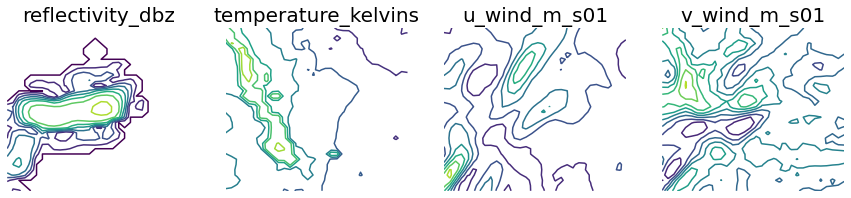

In [ ]:
print("Sample storm image:")
plot_storm_array(storm_array, labels=feature_names, contour=True)

### Load all test data

In [ ]:
# Get list of test data files
image_testing_file_names = image_utils.find_many_files(
    first_date_string='20160101', last_date_string='20171231',
    directory_name=local_image_directory)

# Read all into dictionary
testing_image_dict = image_utils.read_many_files(image_testing_file_names)

# For simplicity, rename to `data`
data = testing_image_dict

## Preprocessing


**Calculate normalization parameters**

- mean & standard deviation of each feature map



In [ ]:
image_normalization_dict = image_normalization.get_normalization_params(image_dict=data)
print(image_normalization_dict)

{'reflectivity_dbz': array([22.93735526, 15.78965926]), 'temperature_kelvins': array([289.71091091,   7.96313792]), 'u_wind_m_s01': array([-0.60646771,  4.51106559]), 'v_wind_m_s01': array([0.50946755, 5.26410041])}


In [ ]:
print("Feature map normalization parameters:")
for key in image_normalization_dict.keys():
  print("  {}: \t(mean = {:.4f}, std. dev. = {:.4f})".format(key, 
                                                                 image_normalization_dict[key][0], 
                                                                 image_normalization_dict[key][1]) )

Feature map normalization parameters:
  reflectivity_dbz: 	(mean = 22.9374, std. dev. = 15.7897)
  temperature_kelvins: 	(mean = 289.7109, std. dev. = 7.9631)
  u_wind_m_s01: 	(mean = -0.6065, std. dev. = 4.5111)
  v_wind_m_s01: 	(mean = 0.5095, std. dev. = 5.2641)


**Find binarization threshold:**

- Finds the binarization threshold (on max future vorticity in s−1)
- Via 90th percentile

In [ ]:
image_binarization_threshold = image_thresholding.get_binarization_threshold(image_dict=data, percentile_level=90.)


Binarization threshold for "max_future_vorticity_s01" = 6.1918e-03


**Test CNN prediction**

In [ ]:
predictor_matrix_denorm = data[image_utils.PREDICTOR_MATRIX_KEY]
predictor_names = data[image_utils.PREDICTOR_NAMES_KEY]
predictor_matrix_norm = image_normalization.normalize_data(
    predictor_matrix=copy.deepcopy(predictor_matrix_denorm),
    predictor_names=predictor_names, normalization_dict=image_normalization_dict
)

# Predict the first 5
preds = cnn_model_object.predict(predictor_matrix_norm[0][0:5,:])
print(preds)

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


[[0.1550841 ]
 [0.00978115]
 [0.01331779]
 [0.06138796]
 [0.03611451]]


**Organize by extreme case types**

In [ ]:
# Best hits
best_hits_matrix_denorm = predictor_matrix_denorm[best_hit_indices]
best_hits_matrix_norm = (
    predictor_matrix_norm[0][best_hit_indices],
    predictor_matrix_norm[1]
)

# Worst false alarms
worst_false_alarm_matrix_denorm = predictor_matrix_denorm[worst_false_alarm_indices]
worst_false_alarm_matrix_norm = (
    predictor_matrix_norm[0][worst_false_alarm_indices],
    predictor_matrix_norm[1]
)

# Worst misses
worst_miss_matrix_denorm = predictor_matrix_denorm[worst_miss_indices]
worst_miss_matrix_norm = (
    predictor_matrix_norm[0][worst_miss_indices],
    predictor_matrix_norm[1]
)

# Best correst nulls
best_correct_null_matrix_denorm = predictor_matrix_denorm[best_correct_null_indices]
best_correct_null_matrix_norm = (
    predictor_matrix_norm[0][best_correct_null_indices],
    predictor_matrix_norm[1]
)

**Create probability-matched mean storms that represent each of the four extreme cases**

In [ ]:
# Best hits
pmm_best_hits_matrix_denorm = utils.run_pmm_many_variables(predictor_matrix_denorm[best_hit_indices])
# Worst false alarms
pmm_worst_false_alarm_matrix_denorm = utils.run_pmm_many_variables(predictor_matrix_denorm[worst_false_alarm_indices])
# Worst misses
pmm_worst_miss_matrix_denorm = utils.run_pmm_many_variables(predictor_matrix_denorm[worst_miss_indices])
# Best correst nulls
pmm_best_correct_null_matrix_denorm = utils.run_pmm_many_variables(predictor_matrix_denorm[best_correct_null_indices])

**Find feature map variable ranges to properly scale plots**

In [ ]:
# Combine all extreme cases
concat_predictor_matrix = np.stack((
    best_hits_matrix_denorm, worst_false_alarm_matrix_denorm,
    worst_miss_matrix_denorm, best_correct_null_matrix_denorm,
), axis=0)

# Temperature: find 1-th prctle & 99th prctile across all above cases
temperature_matrix_kelvins = concat_predictor_matrix[
    ..., predictor_names.index(image_utils.TEMPERATURE_NAME)
]
min_temp_kelvins = np.percentile(temperature_matrix_kelvins, 1)
max_temp_kelvins = np.percentile(temperature_matrix_kelvins, 99)

# Wind speed: find 99th prctile across all above cases
max_speed_m_s01 = np.percentile(
    np.absolute(concat_predictor_matrix[..., 2:4]), 99
)

## Apply XAI techniques

In [ ]:
# Model evaluation function
def m(X):
  return cnn_model_object.predict(X)

### Channel-wise `PartitionShap`

SHAP value visualization color scheme:

- Red: raster region contributed **toward** tornadic case
  - Toward higher probability of  low-level vorticity exceeding threshold 
- Blue: raster region contributed **away from** tornadic case
  - Toward lower probability of  low-level vorticity exceeding threshold 


Each of the following plots is has 3 rows and four columns

- Columns: the 4 channels (feature maps)
- Rows: 
  - row 1: feature map data values
  - row 2: SHAP values, colors relative across all four channels 
  - row 3: SHAP values, colors relative to the single channel

**Define masking methods**

In [ ]:
# Sample data to get shape
X = best_hits_matrix_norm[0][0:1]

# Masking methods
masker_uniform_0  = shap.maskers.Image(np.zeros_like(X[0]), X[0].shape, partition_scheme=1)
masker_blur_10x10 = shap.maskers.Image("blur(10, 10)", X[0].shape, partition_scheme=1)
masker_blur_32x32 = shap.maskers.Image("blur(32, 32)", X[0].shape, partition_scheme=1)

**Define SHAP evaluation function**

In [ ]:
def explain_multiband(data, masker):
  # Initialize PartitionShap explainer
  explainer = shap.Explainer(m, masker)

  # Explain batch (calculate SHAP values)
  shap_values = explainer(data, max_evals=5000)

  return shap_values

**Define custon SHAP value plot function**

In [ ]:
def plot_storm_shap(values, shap_values):
  '''
    values: M-by-N-by-4
    shap_values: M-by-N-by-4
  '''

  from shap.plots import colors
  import matplotlib

  THIS_COLOUR_LIST = [
    np.array([4, 233, 231]), np.array([1, 159, 244]),
    np.array([3, 0, 244]),   np.array([2, 253, 2]),
    np.array([1, 197, 1]),   np.array([0, 142, 0]),
    np.array([253, 248, 2]), np.array([229, 188, 0]),
    np.array([253, 149, 0]), np.array([253, 0, 0]),
    np.array([212, 0, 0]),   np.array([188, 0, 0]),
    np.array([248, 0, 253]), np.array([152, 84, 198])
  ]
  for p in range(len(THIS_COLOUR_LIST)):
    THIS_COLOUR_LIST[p] = THIS_COLOUR_LIST[p].astype(float) / 255

  REFL_COLOUR_MAP_OBJECT = matplotlib.colors.ListedColormap(THIS_COLOUR_LIST)
  REFL_COLOUR_MAP_OBJECT.set_under(np.ones(3))
  THESE_COLOUR_BOUNDS = np.array([
      0.1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70
  ])
  REFL_COLOUR_NORM_OBJECT = matplotlib.colors.BoundaryNorm(
      THESE_COLOUR_BOUNDS, REFL_COLOUR_MAP_OBJECT.N
  )

  fig, ax = plt.subplots(3, 4, figsize=(24, 18))

  values = copy.deepcopy(values)
  values = np.squeeze(values)
  shap_values = copy.deepcopy(shap_values)
  # shap_values = np.abs(shap_values)
  shap_values = np.squeeze(shap_values)

  abs_vals = np.abs(shap_values.sum(-1))
  max_val = np.nanpercentile(abs_vals, 99.9)

  # Reflectivity
  ax[0][0].set_title("Reflectivity (dbz)")
  ax[0][0].pcolormesh(values[:,:,0], 
                      cmap=REFL_COLOUR_MAP_OBJECT,
                      norm=REFL_COLOUR_NORM_OBJECT,
                      vmin=None,
                      vmax=None,
                      shading="flat", edgecolors='None')
  ax[0][0].axis('off')
  ax[1][0].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  ax[1][0].imshow(shap_values[:,:,0], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][0].invert_yaxis()
  ax[1][0].axis('off')
  ax[2][0].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  local_abs_vals = np.abs(shap_values[:,:,0])
  local_max_val = np.nanpercentile(local_abs_vals, 99.9)
  ax[2][0].imshow(shap_values[:,:,0], cmap=colors.red_transparent_blue, vmin=-local_max_val, vmax=local_max_val)  
  ax[2][0].invert_yaxis()
  ax[2][0].axis('off')

  # Temperature
  ax[0][1].set_title("Temp (k) & wind field")
  ax[0][1].pcolormesh(values[:,:,1], 
                      cmap='YlOrRd',
                      norm=None,
                      vmin=min_temp_kelvins,
                      vmax=max_temp_kelvins,
                      shading="flat", edgecolors='None')
  ax[0][1].axis('off')
  ax[1][1].imshow(values[:,:,1], cmap="gray", alpha=0.15)
  ax[1][1].imshow(shap_values[:,:,1], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][1].invert_yaxis()
  ax[1][1].axis('off')
  ax[2][1].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  local_abs_vals = np.abs(shap_values[:,:,1])
  local_max_val = np.nanpercentile(local_abs_vals, 99.9)
  ax[2][1].imshow(shap_values[:,:,1], cmap=colors.red_transparent_blue, vmin=-local_max_val, vmax=local_max_val)  
  ax[2][1].invert_yaxis()
  ax[2][1].axis('off')

  # Wind barbs
  image_plotting.plot_wind_2d(values[:,:,2], values[:,:,3], ax[0][1])

  # Wind - u
  ax[0][2].set_title("U-wind (m/s)")
  ax[0][2].pcolormesh(values[:,:,2], 
                      cmap='seismic',
                      norm=None,
                      vmin=-1 * max_speed_m_s01,
                      vmax=max_speed_m_s01,
                      shading="flat", edgecolors='None')  
  ax[0][2].axis('off')
  ax[1][2].imshow(values[:,:,2], cmap="gray", alpha=0.15)
  ax[1][2].imshow(shap_values[:,:,2], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][2].invert_yaxis()
  ax[1][2].axis('off')
  ax[2][2].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  local_abs_vals = np.abs(shap_values[:,:,2])
  local_max_val = np.nanpercentile(local_abs_vals, 99.9)
  ax[2][2].imshow(shap_values[:,:,2], cmap=colors.red_transparent_blue, vmin=-local_max_val, vmax=local_max_val)  
  ax[2][2].invert_yaxis()
  ax[2][2].axis('off')

  # Wind - v
  ax[0][3].set_title("V-wind (m/s)")
  ax[0][3].pcolormesh(values[:,:,3], 
                      cmap='seismic',
                      norm=None,
                      vmin=-1 * max_speed_m_s01,
                      vmax=max_speed_m_s01,
                      shading="flat", edgecolors='None')  
  ax[0][3].axis('off')
  ax[1][3].imshow(values[:,:,3], cmap="gray", alpha=0.15)
  ax[1][3].imshow(shap_values[:,:,3], cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
  ax[1][3].invert_yaxis()
  ax[1][3].axis('off')
  ax[2][3].imshow(values[:,:,0], cmap="gray", alpha=0.15)
  local_abs_vals = np.abs(shap_values[:,:,3])
  local_max_val = np.nanpercentile(local_abs_vals, 99.9)
  ax[2][3].imshow(shap_values[:,:,3], cmap=colors.red_transparent_blue, vmin=-local_max_val, vmax=local_max_val)  
  ax[2][3].invert_yaxis()
  ax[2][3].axis('off')

  plt.tight_layout()

def plot_storm_shap_batch(values, shap_values):
  n = values.shape[0]
  for i in range(n):
    v = values[i,:]
    s = shap_values[i]
    plot_storm_shap(v, s)

#### Extreme cases 1: best hits

##### Masker: uniform value = 0

In [ ]:
X = best_hits_matrix_norm[0]
Xplot = best_hits_matrix_denorm
# Evaluate 
shap_values = explain_multiband(X, masker_uniform_0)
# Plot first 5 samples
plot_storm_shap_batch(Xplot[0:5], shap_values[0:5].values)

**Probability-matched mean case**

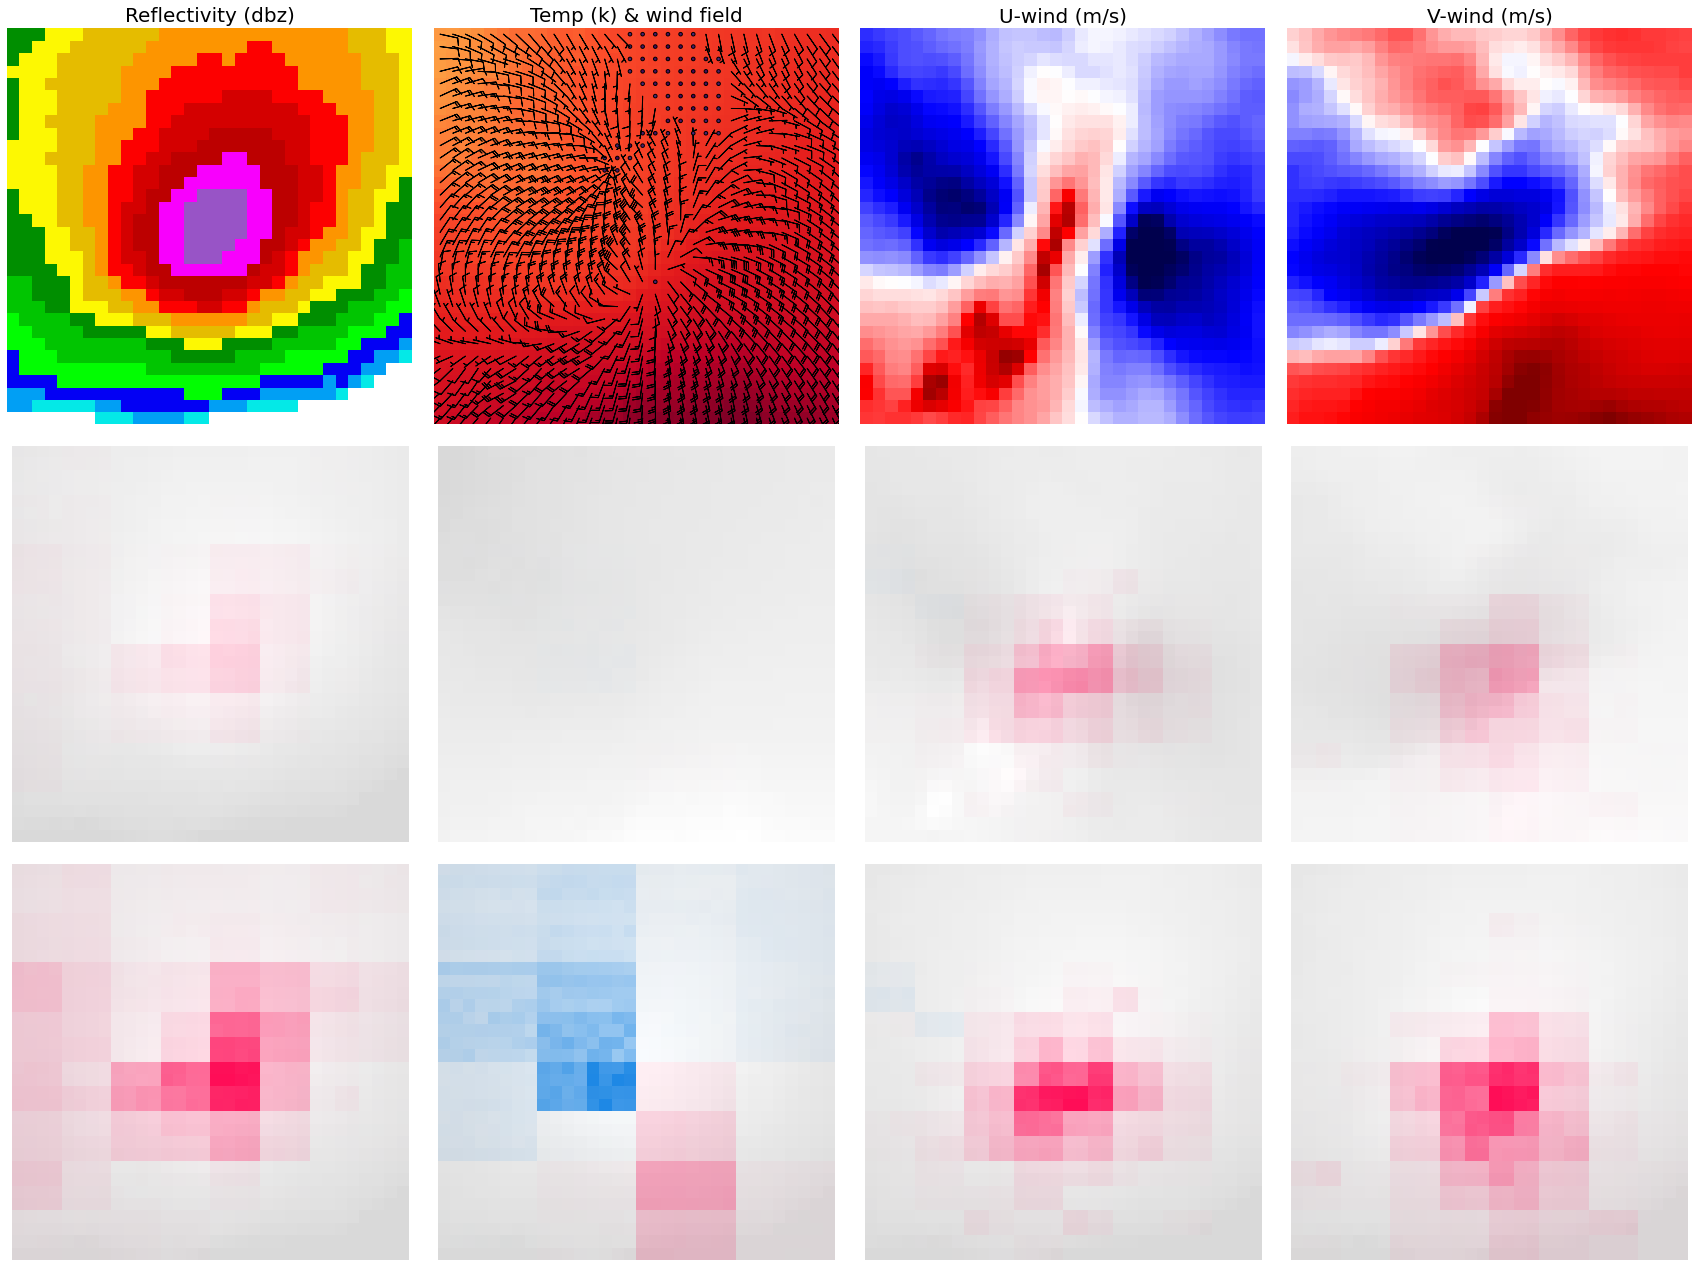

In [ ]:
shap_values_pmm = utils.run_pmm_many_variables(shap_values.values)
plot_storm_shap_batch(np.expand_dims(pmm_best_hits_matrix_denorm, axis=0), 
                      np.expand_dims(shap_values_pmm, axis=0))

##### Masker: blur kernel = (10, 10)

In [ ]:
# Evaluate 
shap_values = explain_multiband(X, masker_blur_10x10)
# Plot first 5 samples
plot_storm_shap_batch(Xplot[0:5], shap_values[0:5].values)

**Probability-matched mean case**

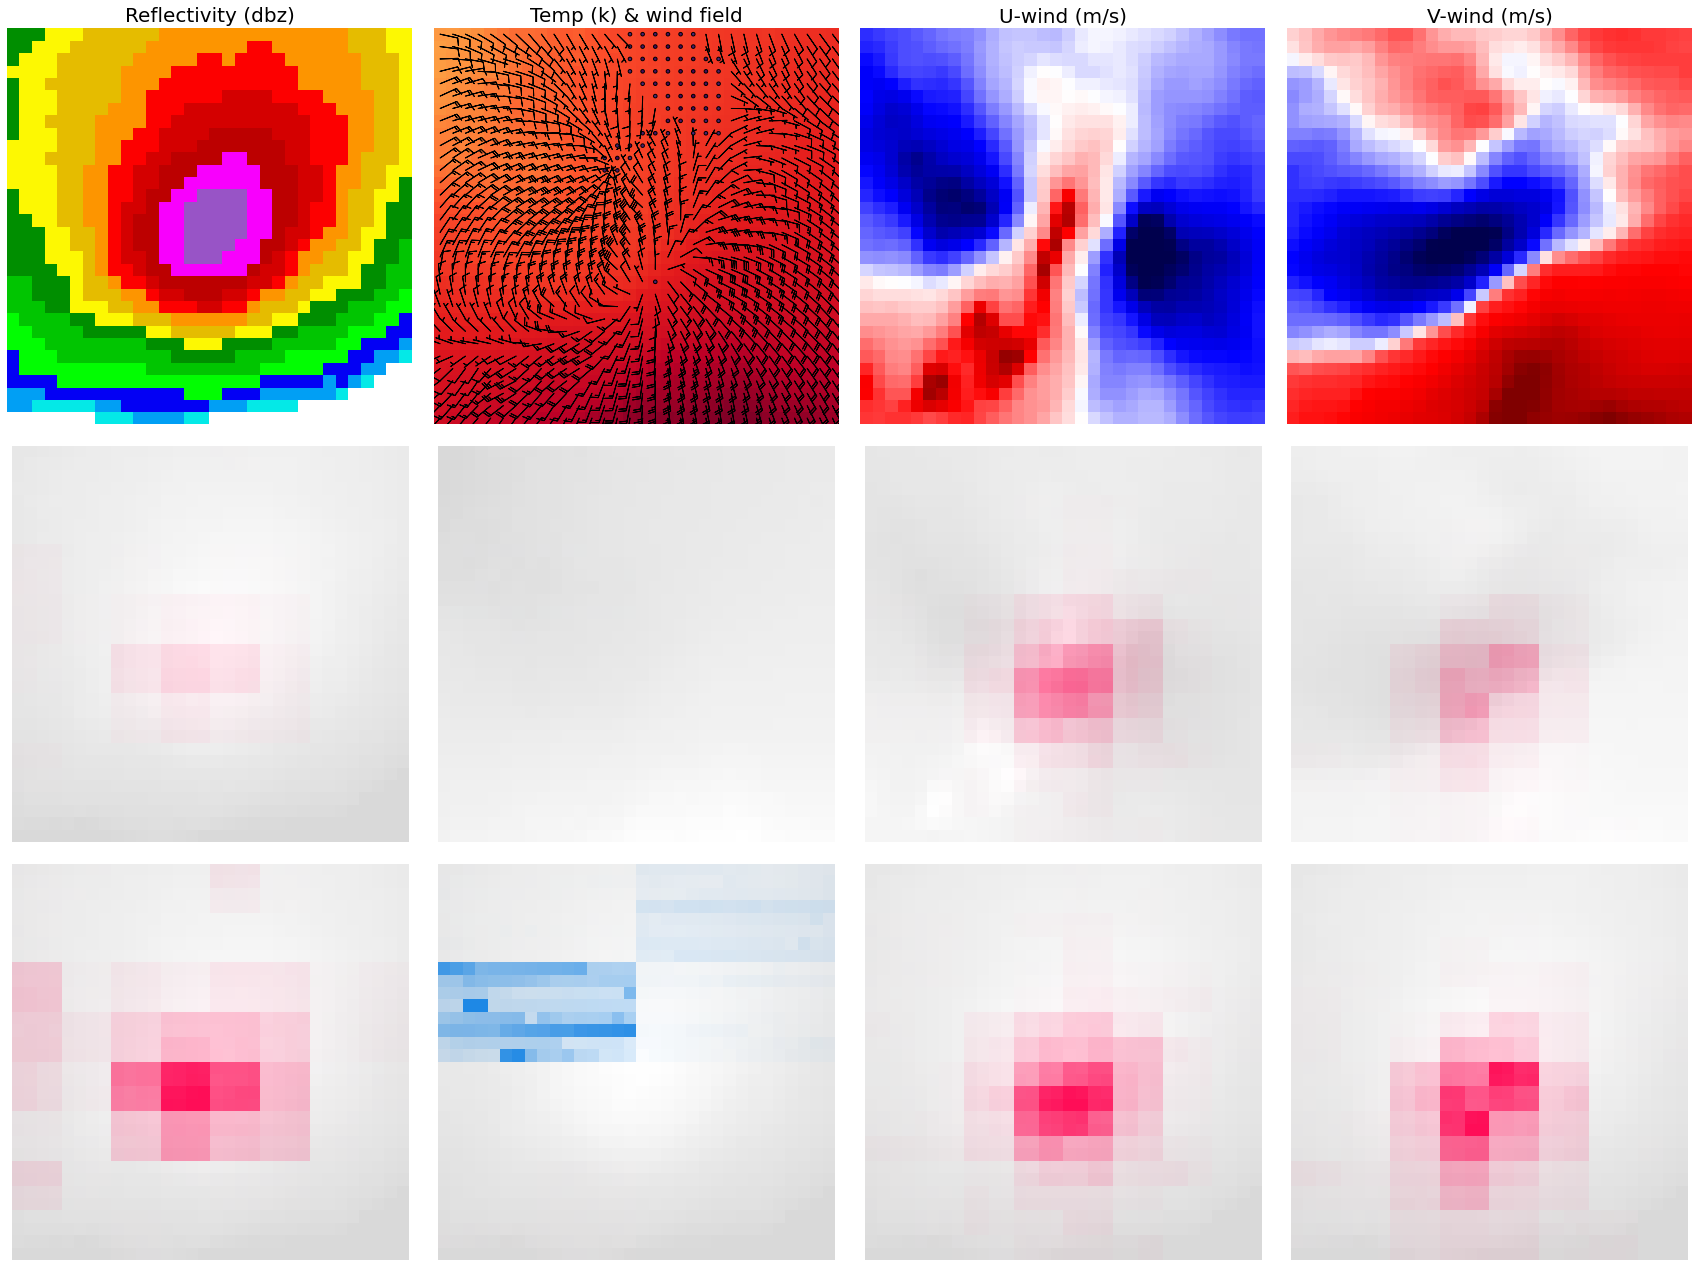

In [ ]:
shap_values_pmm = utils.run_pmm_many_variables(shap_values.values)
plot_storm_shap_batch(np.expand_dims(pmm_best_hits_matrix_denorm, axis=0), 
                      np.expand_dims(shap_values_pmm, axis=0))

##### Masker: blur kernel = (32, 32)

In [ ]:
# Evaluate 
shap_values = explain_multiband(X, masker_blur_32x32)
# Plot first 5 samples
plot_storm_shap_batch(Xplot[0:5], shap_values[0:5].values)

**Probability-matched mean case**

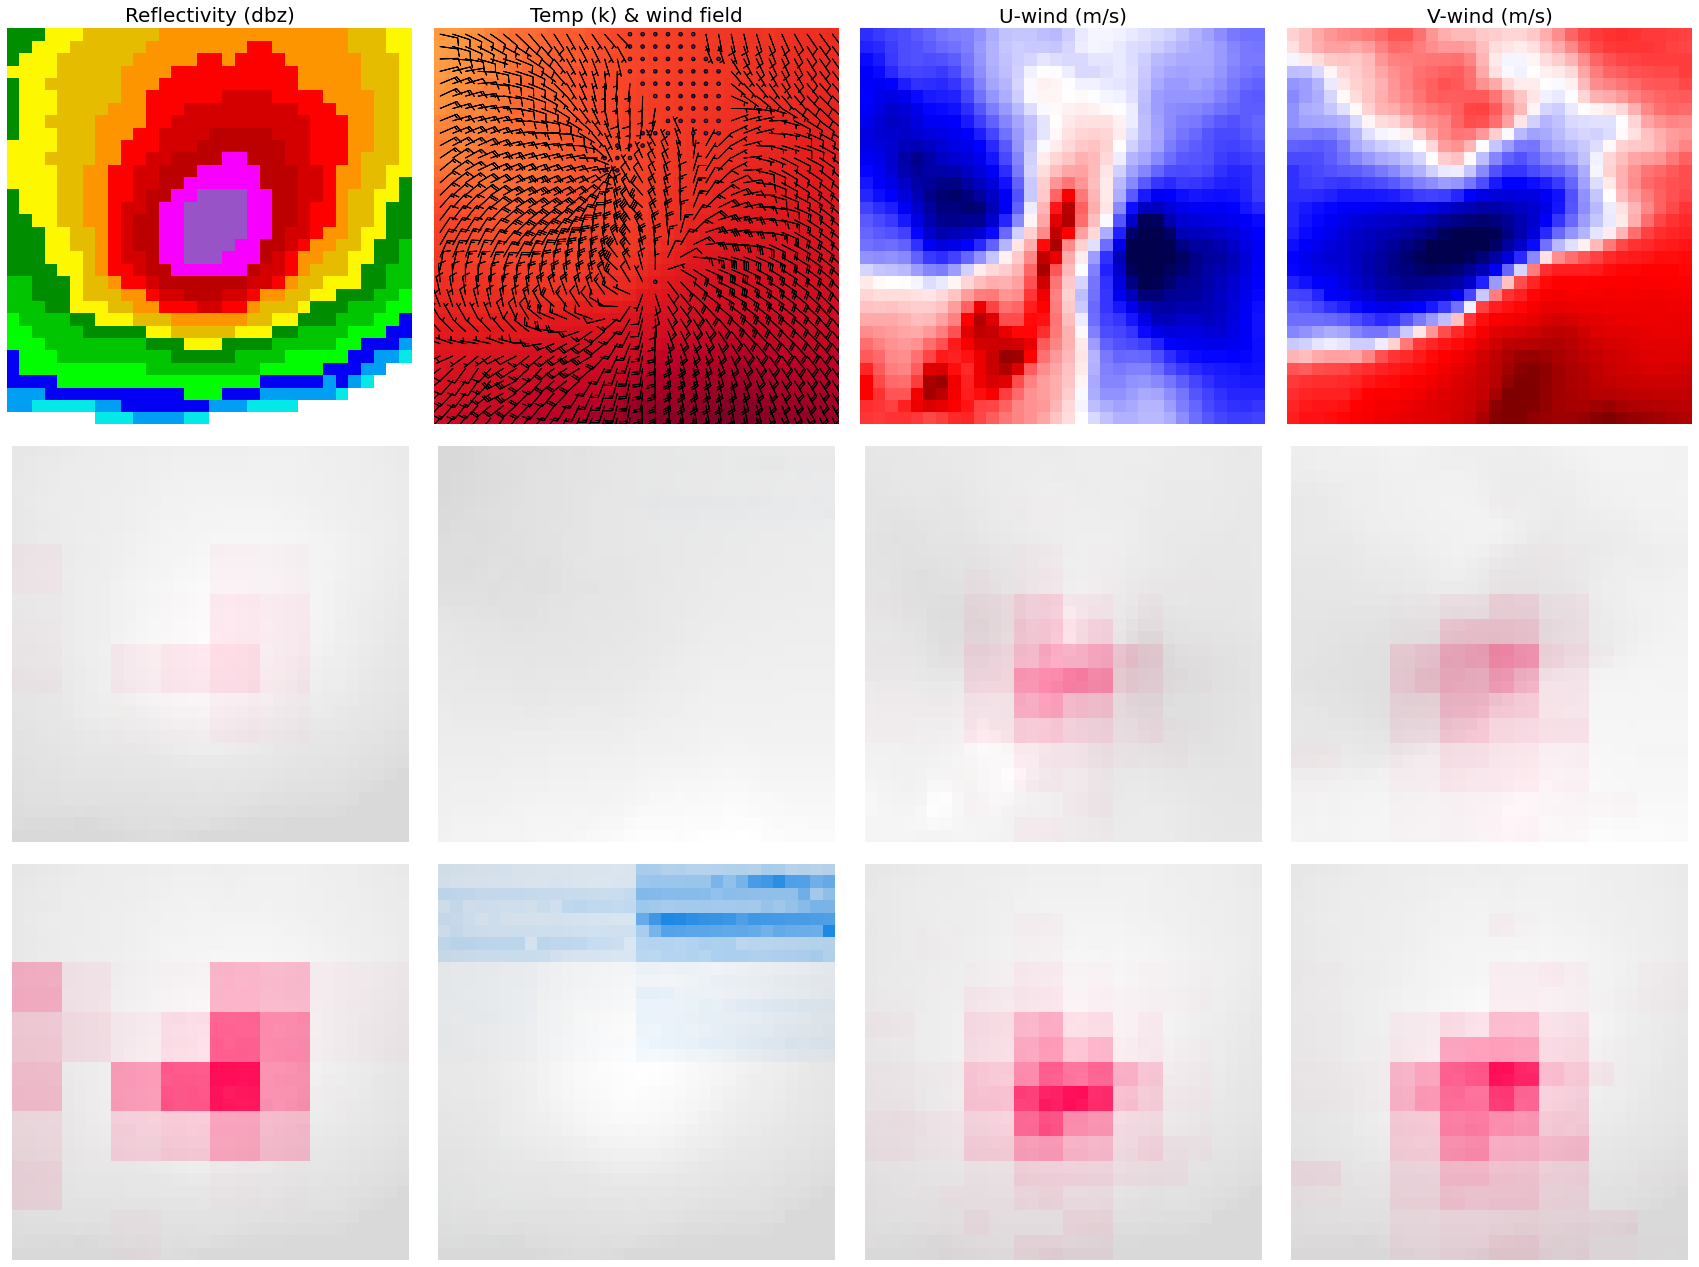

In [ ]:
shap_values_pmm = utils.run_pmm_many_variables(shap_values.values)
plot_storm_shap_batch(np.expand_dims(pmm_best_hits_matrix_denorm, axis=0), 
                      np.expand_dims(shap_values_pmm, axis=0))

#### Extreme cases 2: worst false alarms


##### Masker: uniform value = 0

In [ ]:
X = worst_false_alarm_matrix_norm[0]
Xplot = worst_false_alarm_matrix_denorm
# Evaluate 
shap_values = explain_multiband(X, masker_uniform_0)
# Plot first 5 samples
plot_storm_shap_batch(Xplot[0:5], shap_values[0:5].values)

**Probability-matched mean case**

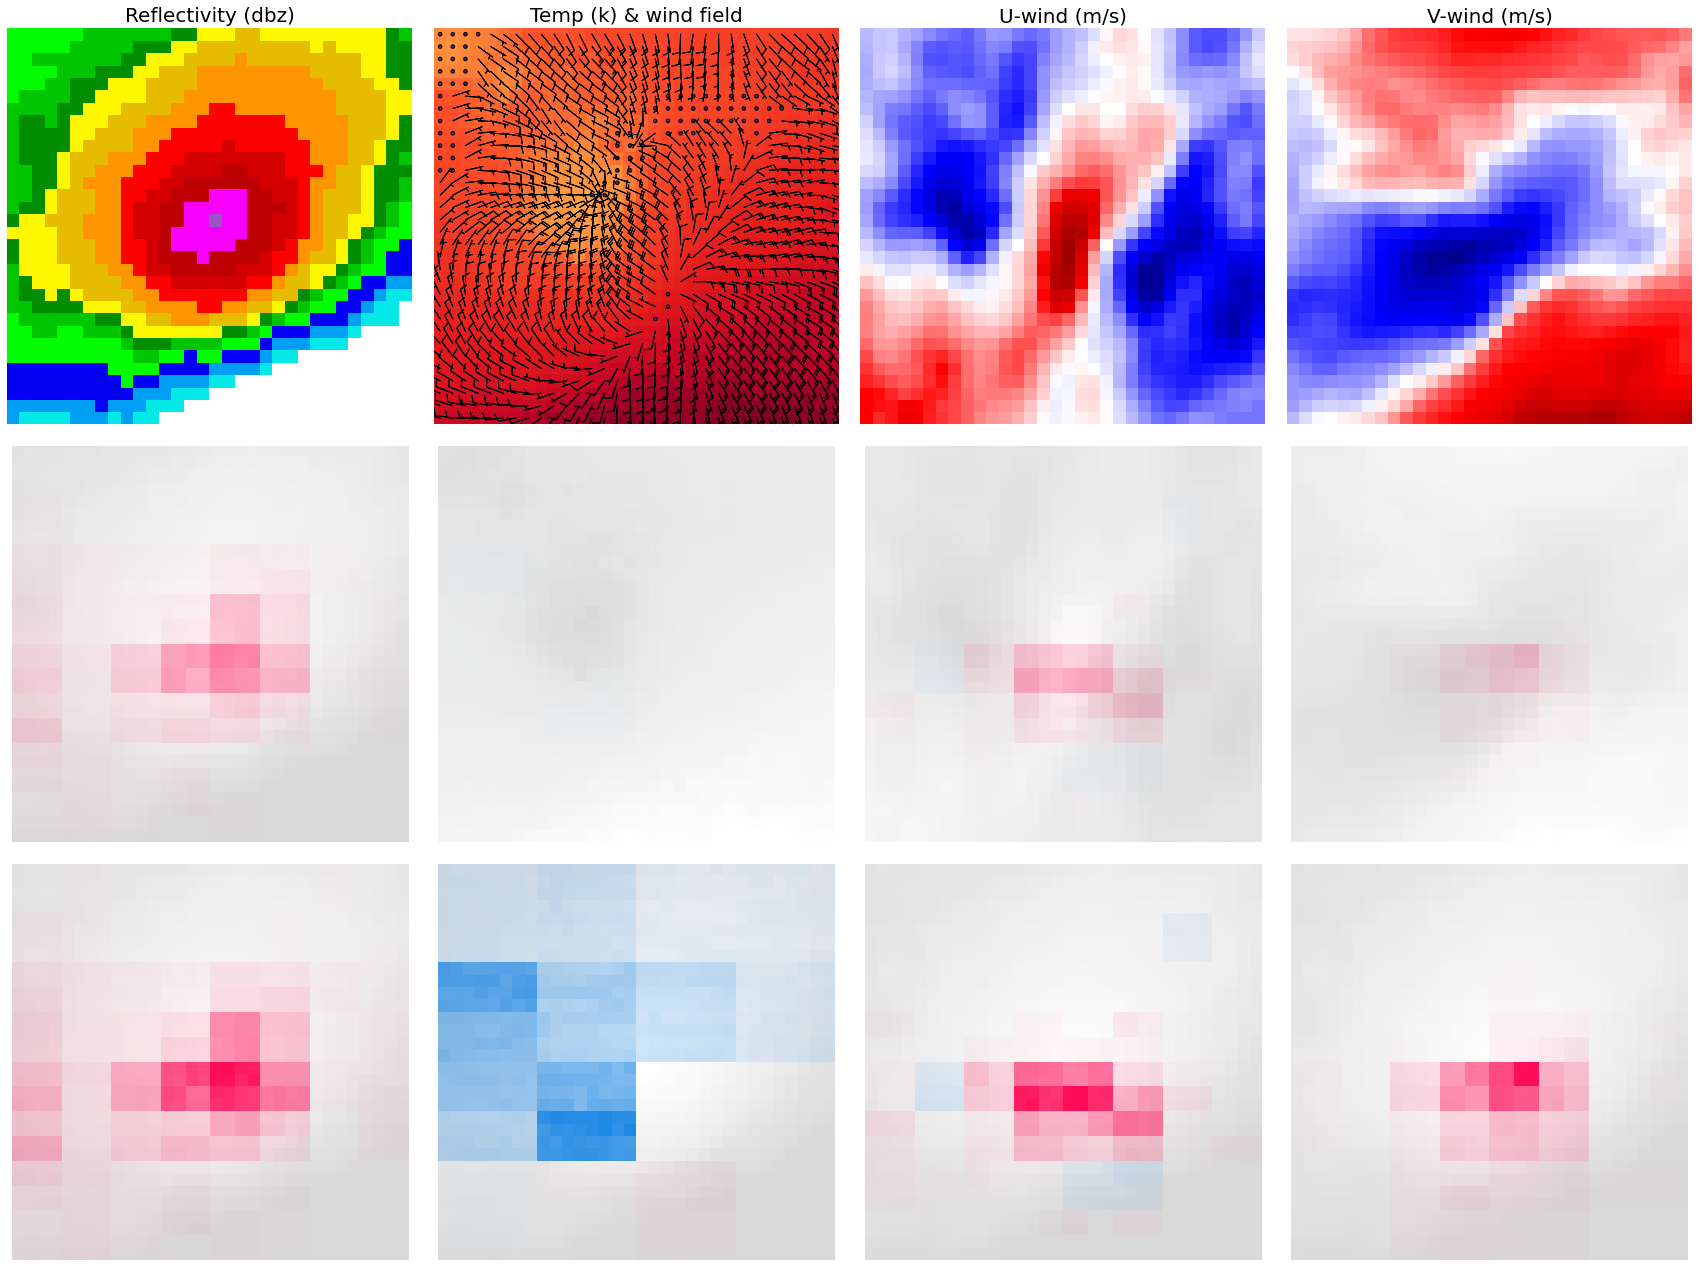

In [ ]:
shap_values_pmm = utils.run_pmm_many_variables(shap_values.values)
plot_storm_shap_batch(np.expand_dims(pmm_worst_false_alarm_matrix_denorm, axis=0), 
                      np.expand_dims(shap_values_pmm, axis=0))

##### Masker: blur kernel = (10, 10)

In [ ]:
# Evaluate 
shap_values = explain_multiband(X, masker_blur_10x10)
# Plot first 5 samples
plot_storm_shap_batch(Xplot[0:5], shap_values[0:5].values)

**Probability-matched mean case**

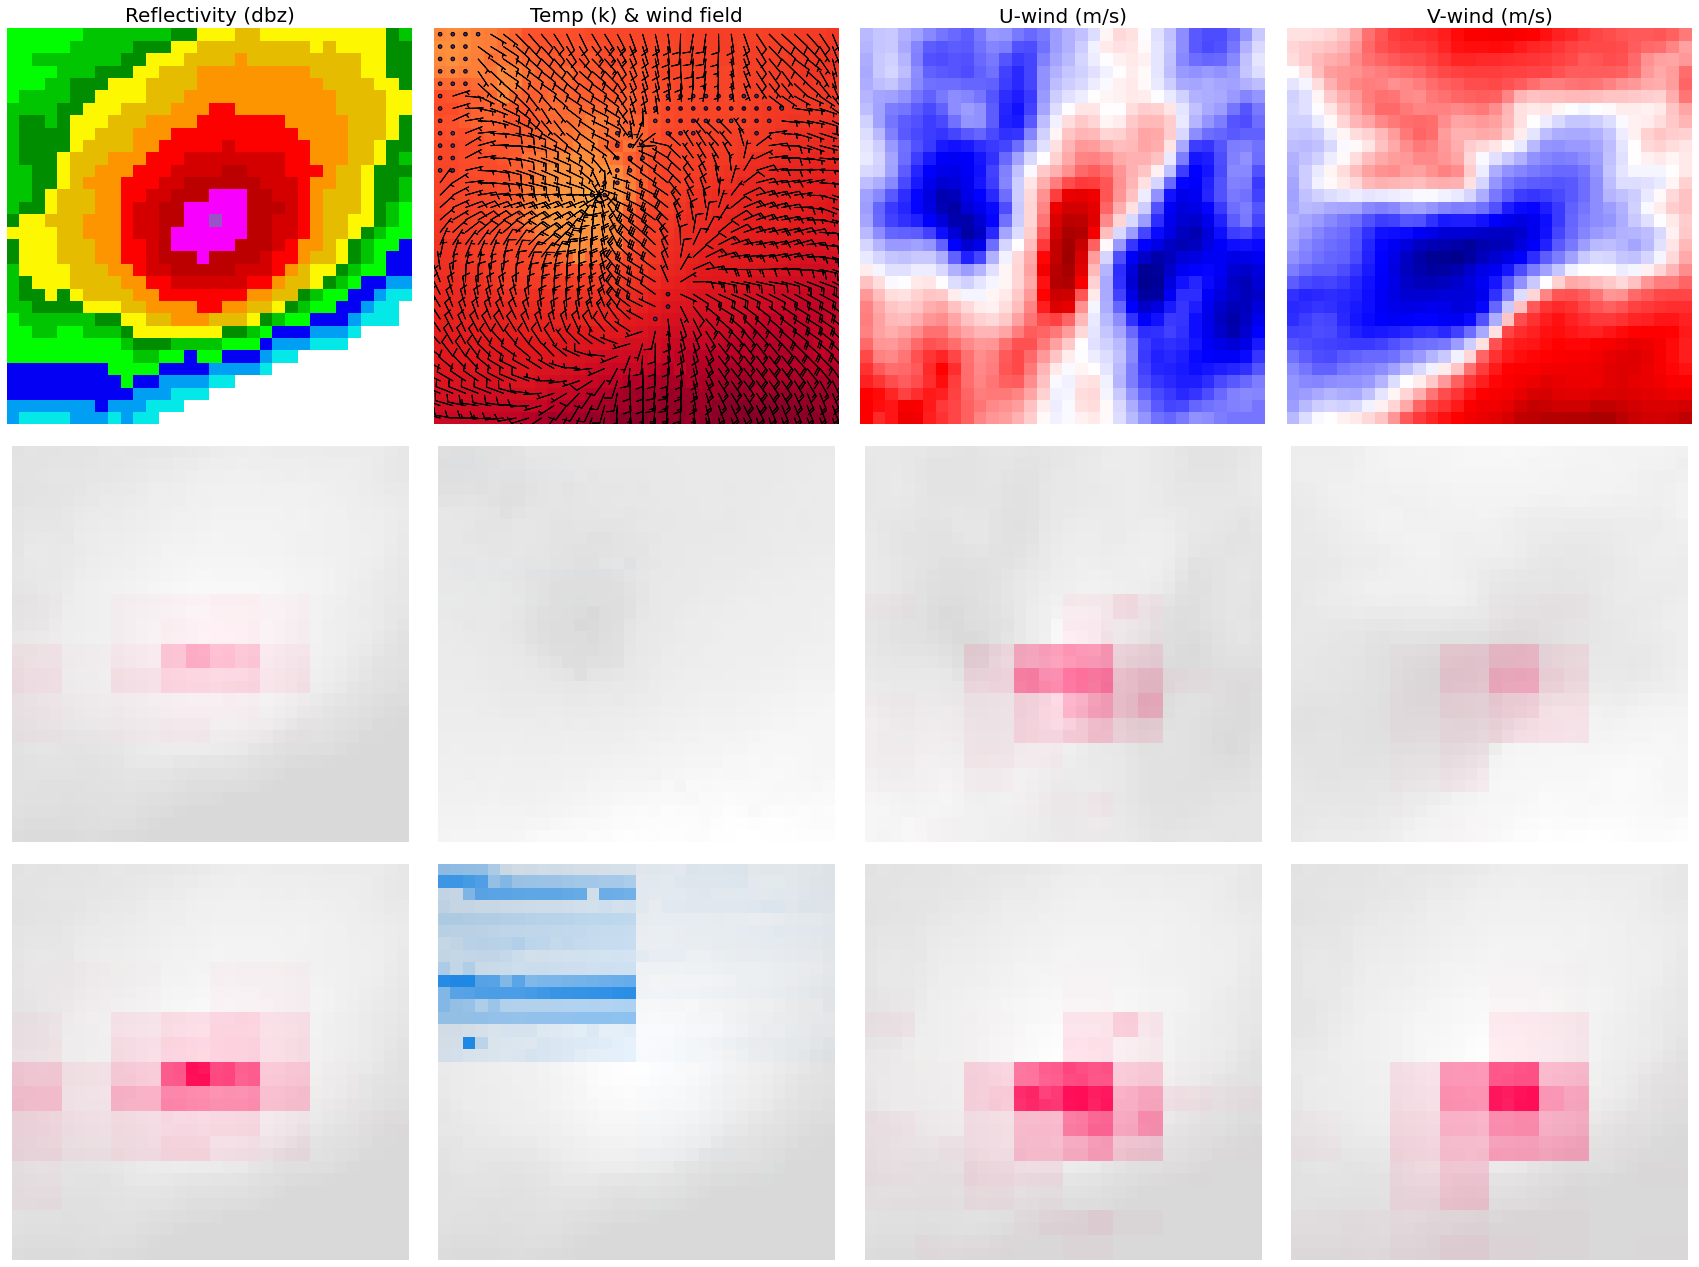

In [ ]:
shap_values_pmm = utils.run_pmm_many_variables(shap_values.values)
plot_storm_shap_batch(np.expand_dims(pmm_worst_false_alarm_matrix_denorm, axis=0), 
                      np.expand_dims(shap_values_pmm, axis=0))

##### Masker: blur kernel = (32, 32)

In [ ]:
# Evaluate 
shap_values = explain_multiband(X, masker_blur_32x32)
# Plot first 5 samples
plot_storm_shap_batch(Xplot[0:5], shap_values[0:5].values)

**Probability-matched mean case**

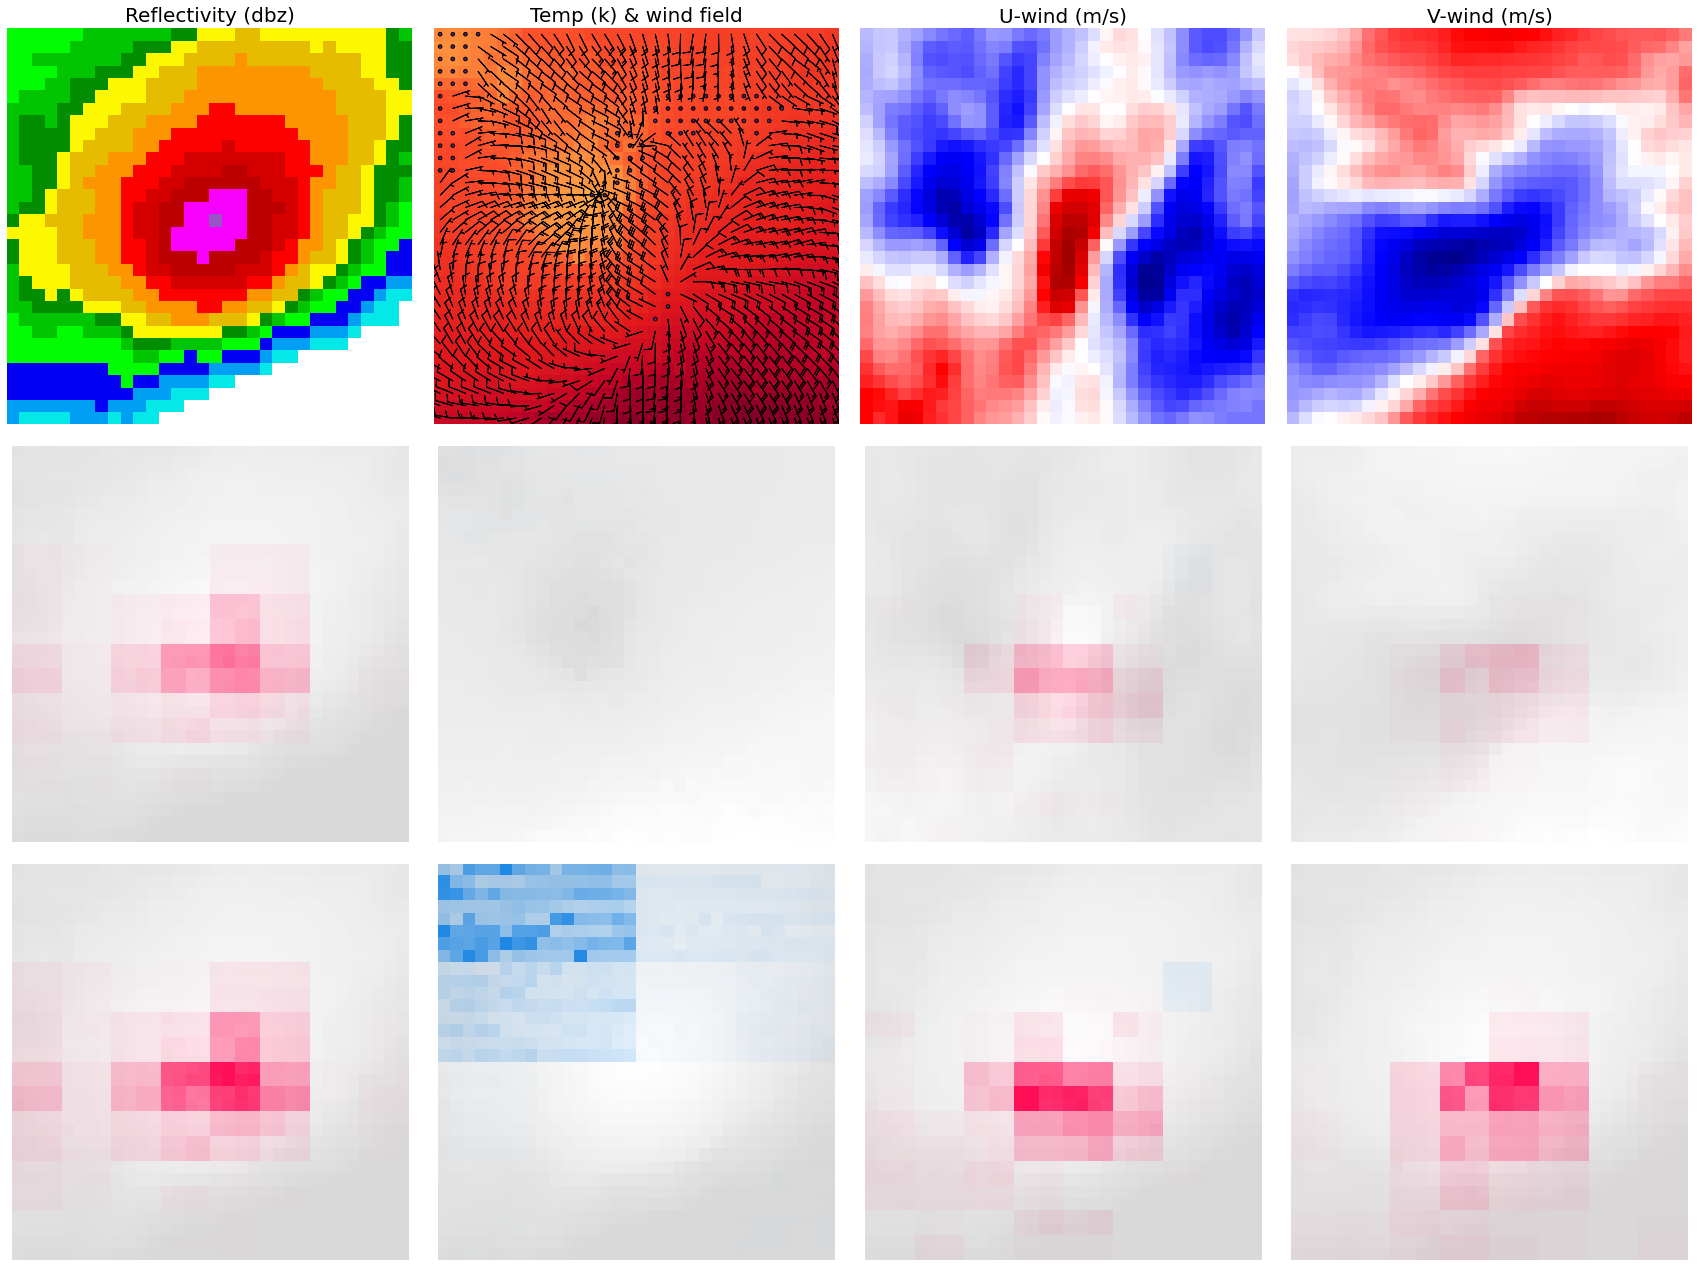

In [ ]:
shap_values_pmm = utils.run_pmm_many_variables(shap_values.values)
plot_storm_shap_batch(np.expand_dims(pmm_worst_false_alarm_matrix_denorm, axis=0), 
                      np.expand_dims(shap_values_pmm, axis=0))

#### Extreme cases 3: worst misses

##### Masker: uniform value = 0

In [ ]:
X = worst_miss_matrix_norm[0]
Xplot = worst_miss_matrix_denorm
# Evaluate 
shap_values = explain_multiband(X, masker_uniform_0)
# Plot first 5 samples
plot_storm_shap_batch(Xplot[0:5], shap_values[0:5].values)

**Probability-matched mean case**

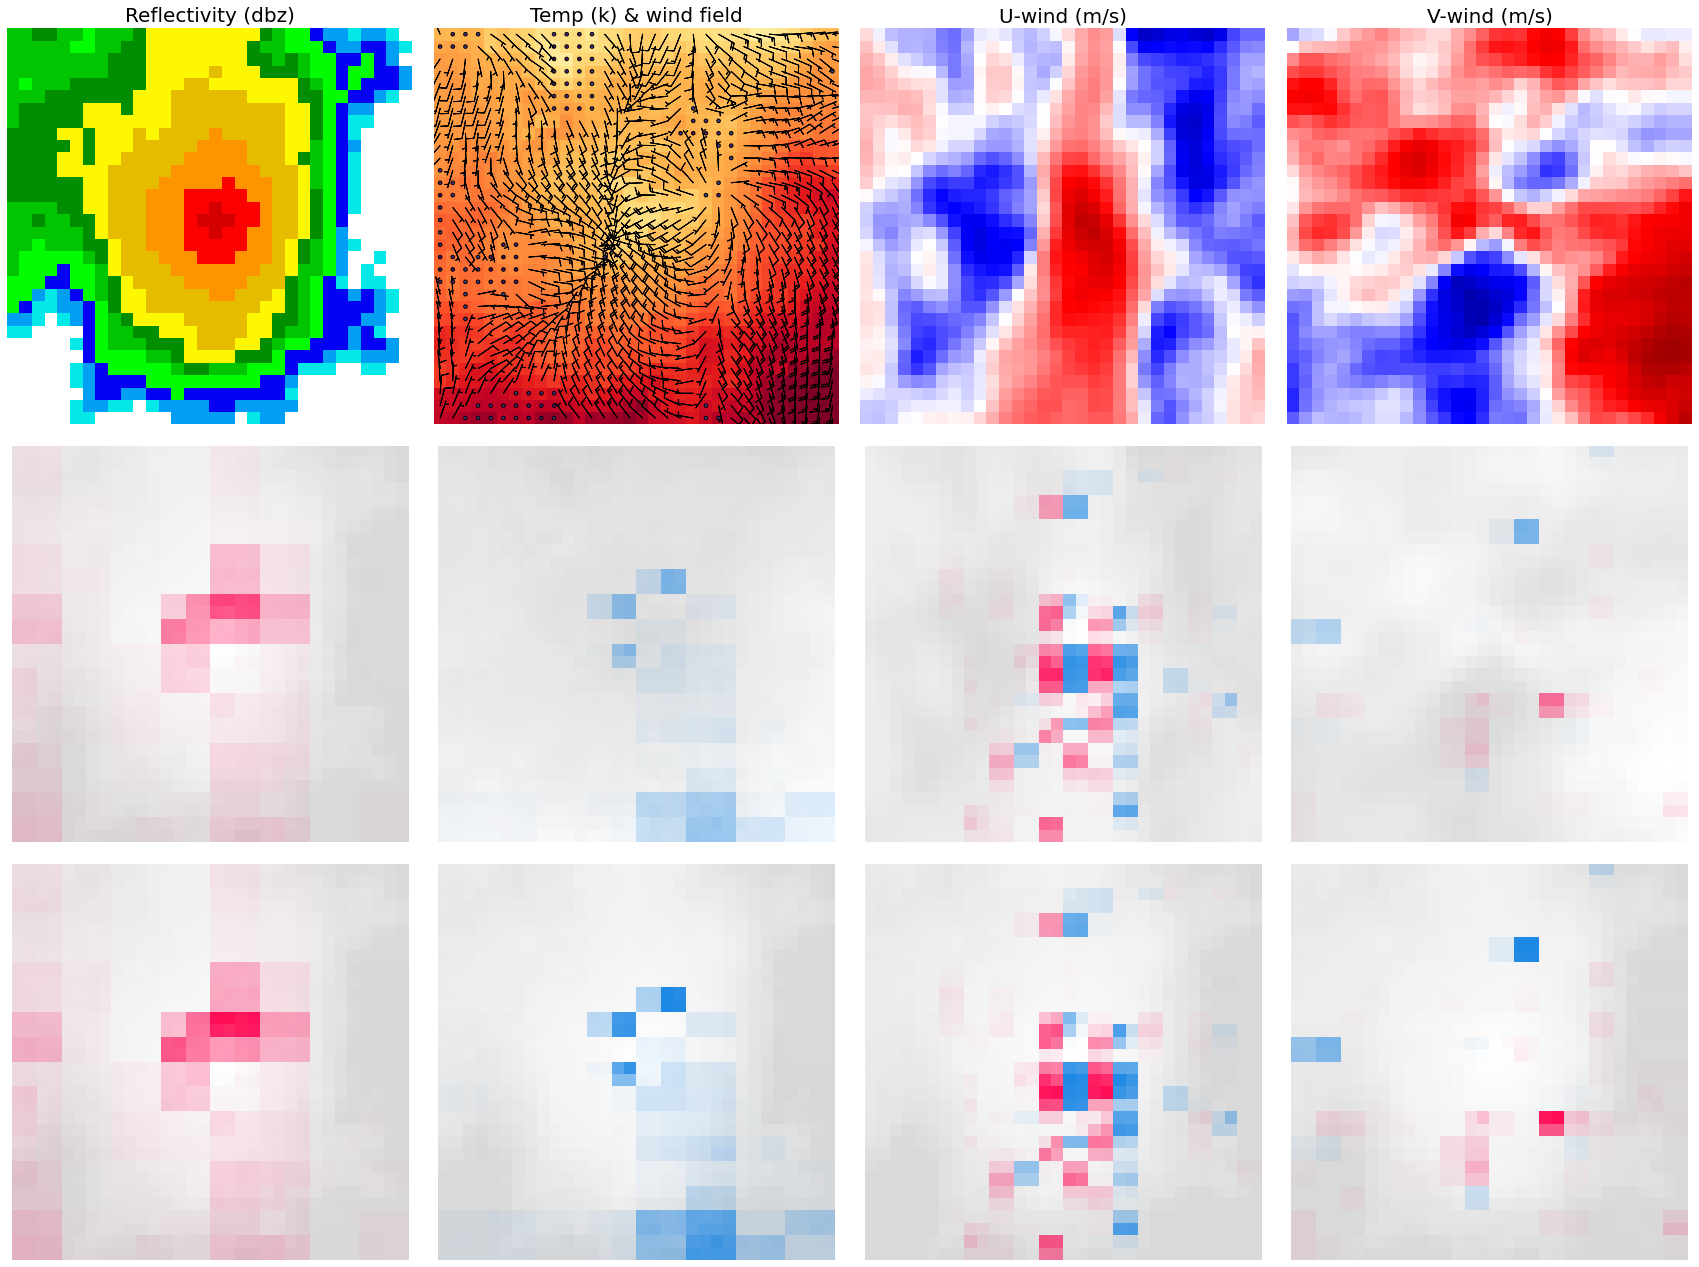

In [ ]:
shap_values_pmm = utils.run_pmm_many_variables(shap_values.values)
plot_storm_shap_batch(np.expand_dims(pmm_worst_miss_matrix_denorm, axis=0), 
                      np.expand_dims(shap_values_pmm, axis=0))

##### Masker: blur kernel = (10, 10)

In [ ]:
# Evaluate 
shap_values = explain_multiband(X, masker_blur_10x10)
# Plot first 5 samples
plot_storm_shap_batch(Xplot[0:5], shap_values[0:5].values)

**Probability-matched mean case**

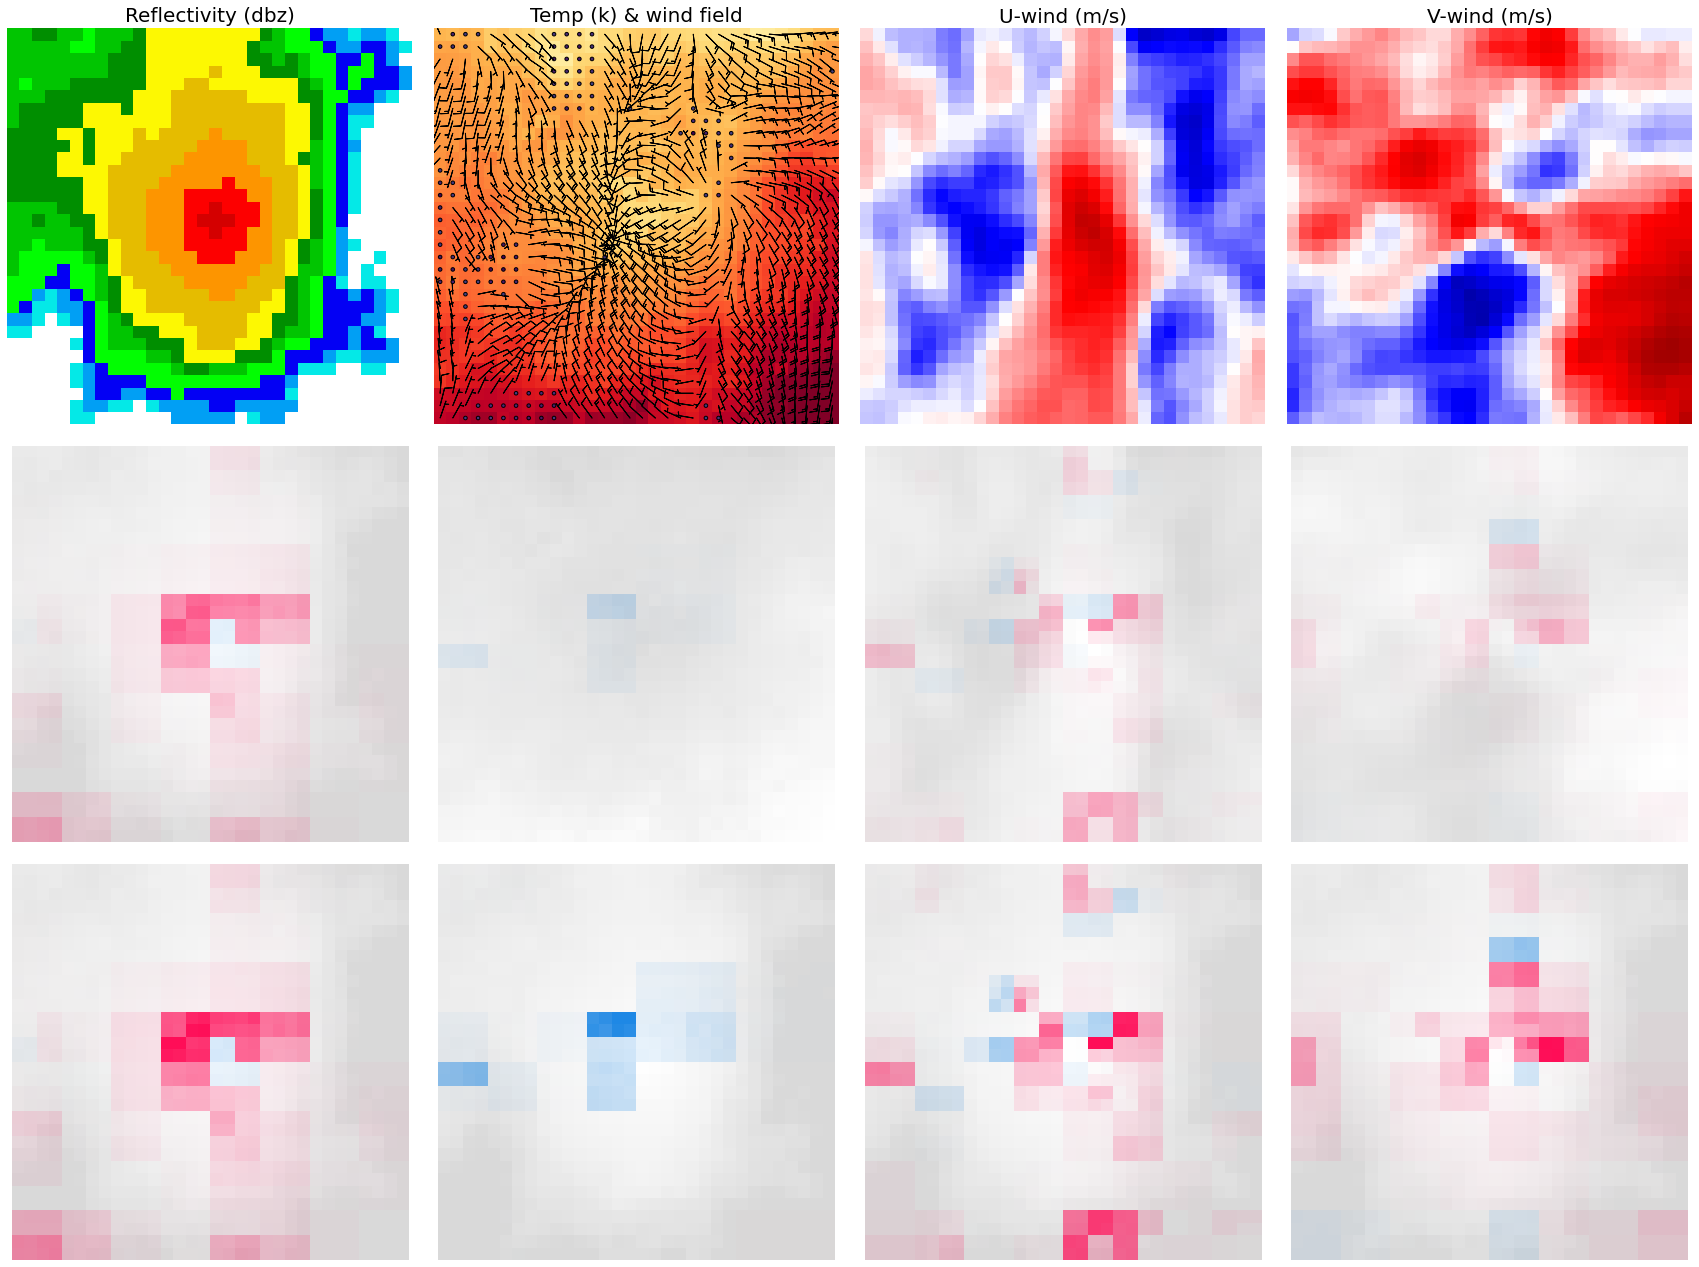

In [ ]:
shap_values_pmm = utils.run_pmm_many_variables(shap_values.values)
plot_storm_shap_batch(np.expand_dims(pmm_worst_miss_matrix_denorm, axis=0), 
                      np.expand_dims(shap_values_pmm, axis=0))

##### Masker: blur kernel = (32, 32)

In [ ]:
# Evaluate 
shap_values = explain_multiband(X, masker_blur_32x32)
# Plot first 5 samples
plot_storm_shap_batch(Xplot[0:5], shap_values[0:5].values)

**Probability-matched mean case**

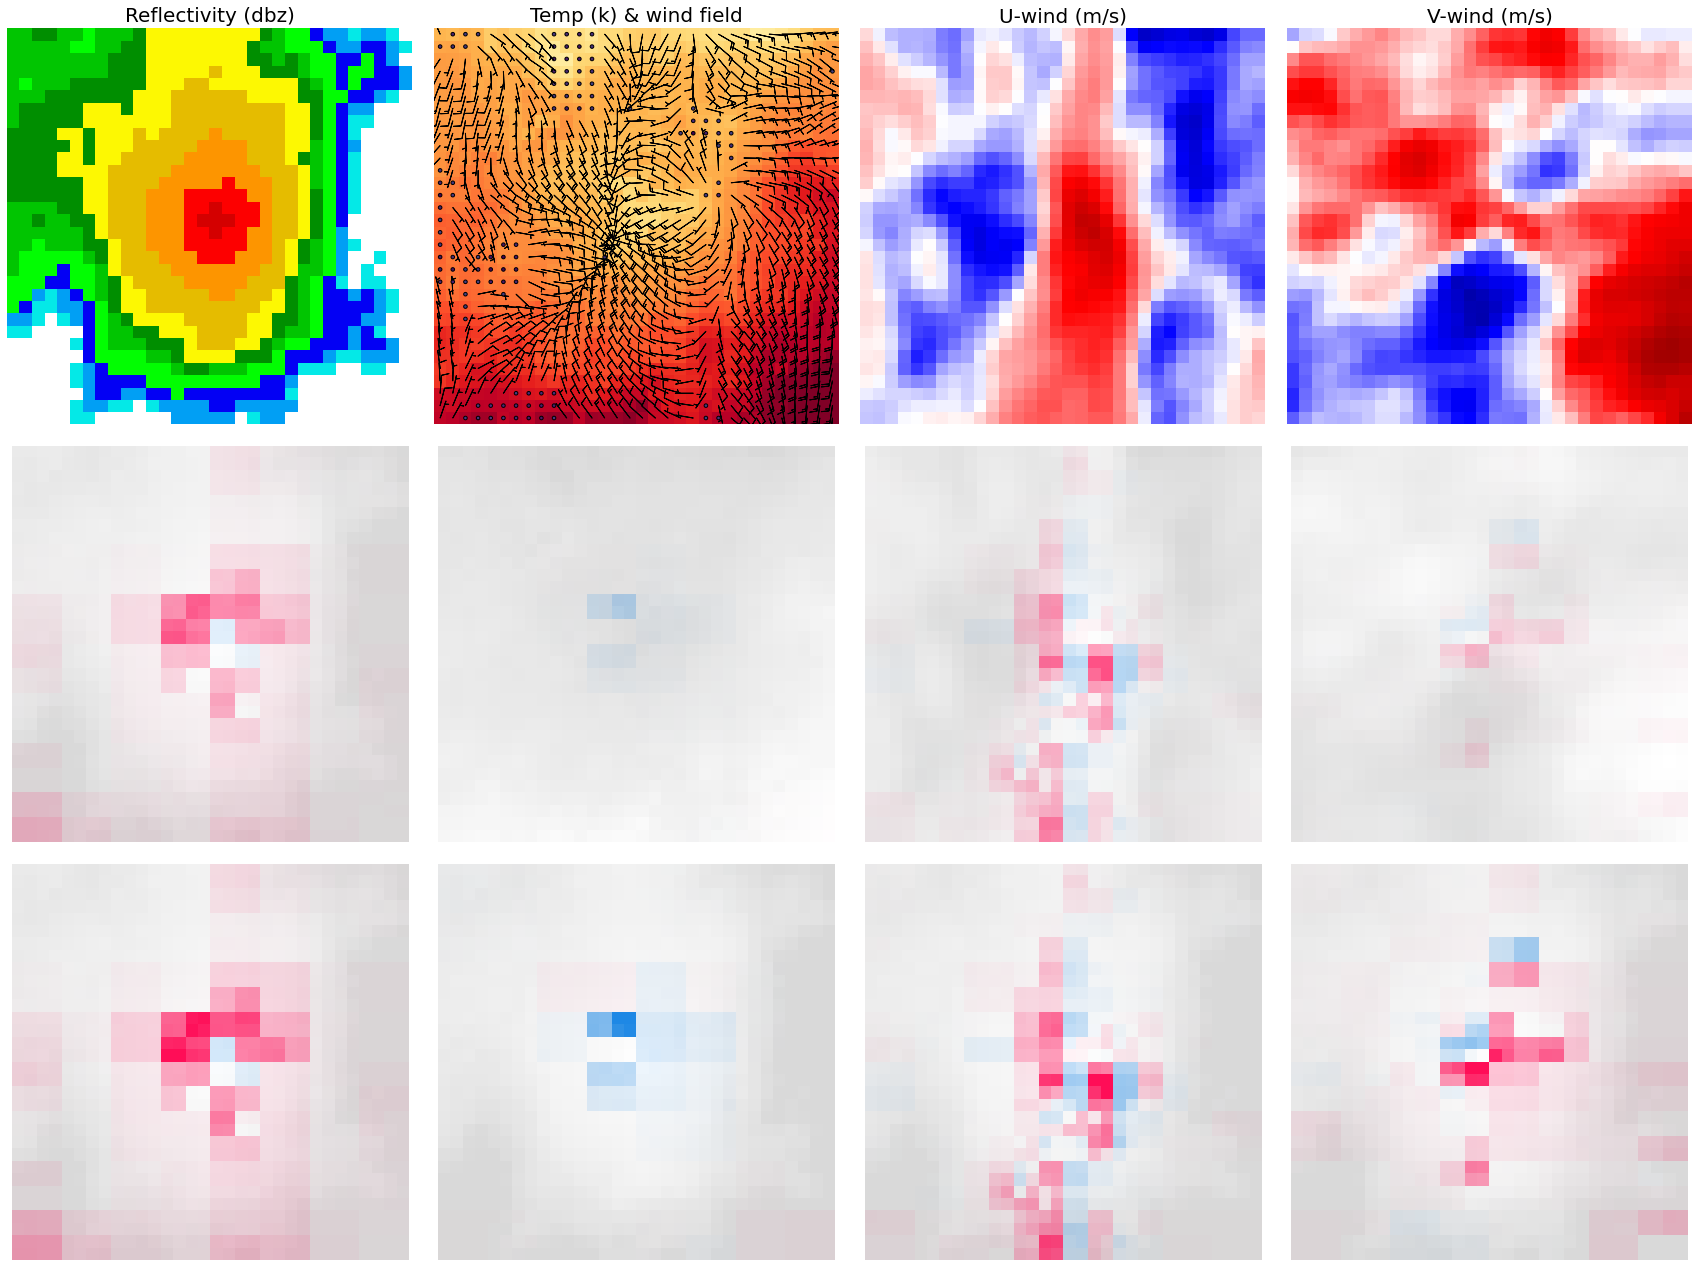

In [ ]:
shap_values_pmm = utils.run_pmm_many_variables(shap_values.values)
plot_storm_shap_batch(np.expand_dims(pmm_worst_miss_matrix_denorm, axis=0), 
                      np.expand_dims(shap_values_pmm, axis=0))

#### Extreme cases 3: best correct nulls

##### Masker: uniform value = 0

In [ ]:
X = best_correct_null_matrix_norm[0]
Xplot = best_correct_null_matrix_denorm
# Evaluate 
shap_values = explain_multiband(X, masker_uniform_0)
# Plot first 5 samples
plot_storm_shap_batch(Xplot[0:5], shap_values[0:5].values)

**Probability-matched mean case**

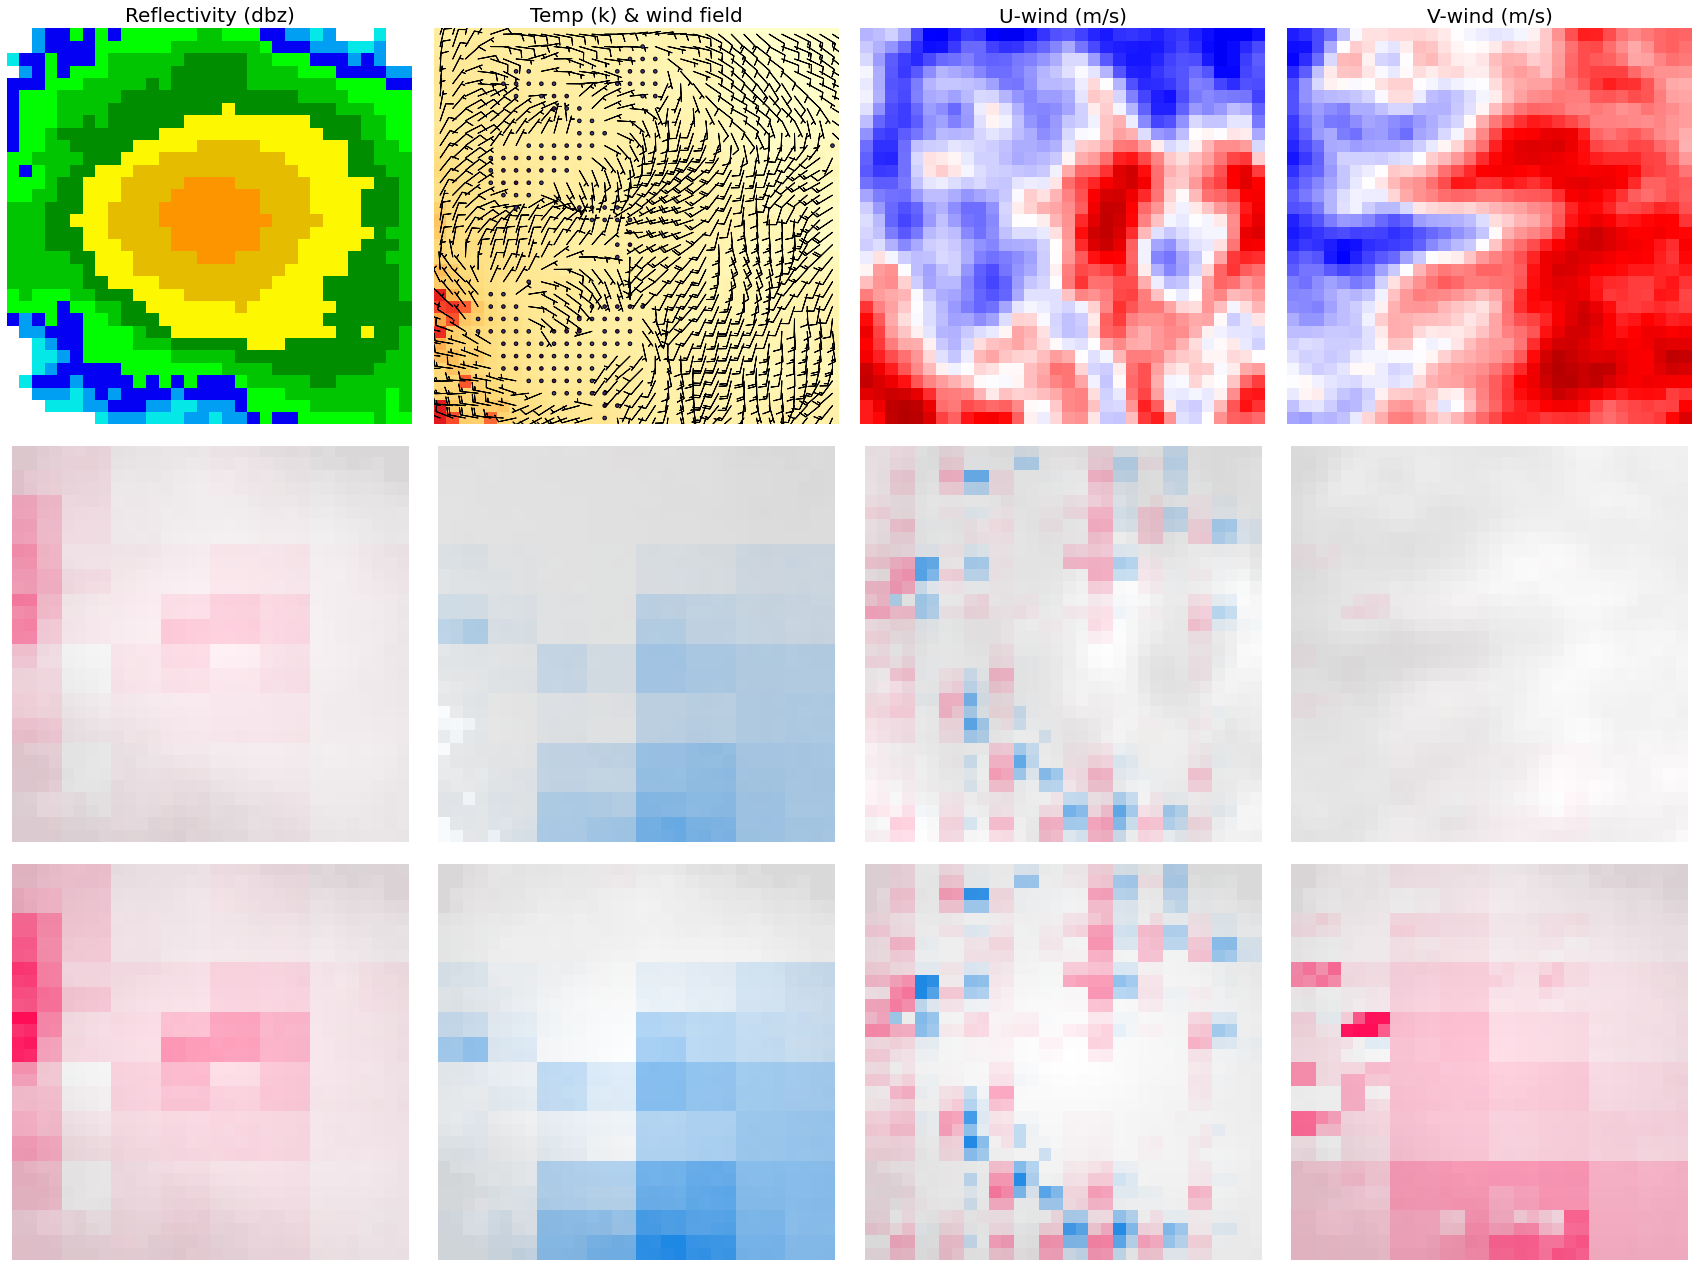

In [ ]:
shap_values_pmm = utils.run_pmm_many_variables(shap_values.values)
plot_storm_shap_batch(np.expand_dims(pmm_best_correct_null_matrix_denorm, axis=0), 
                      np.expand_dims(shap_values_pmm, axis=0))

##### Masker: blur kernel = (10, 10)

In [ ]:
# Evaluate 
shap_values = explain_multiband(X, masker_blur_10x10)
# Plot first 5 samples
plot_storm_shap_batch(Xplot[0:5], shap_values[0:5].values)

**Probability-matched mean case**

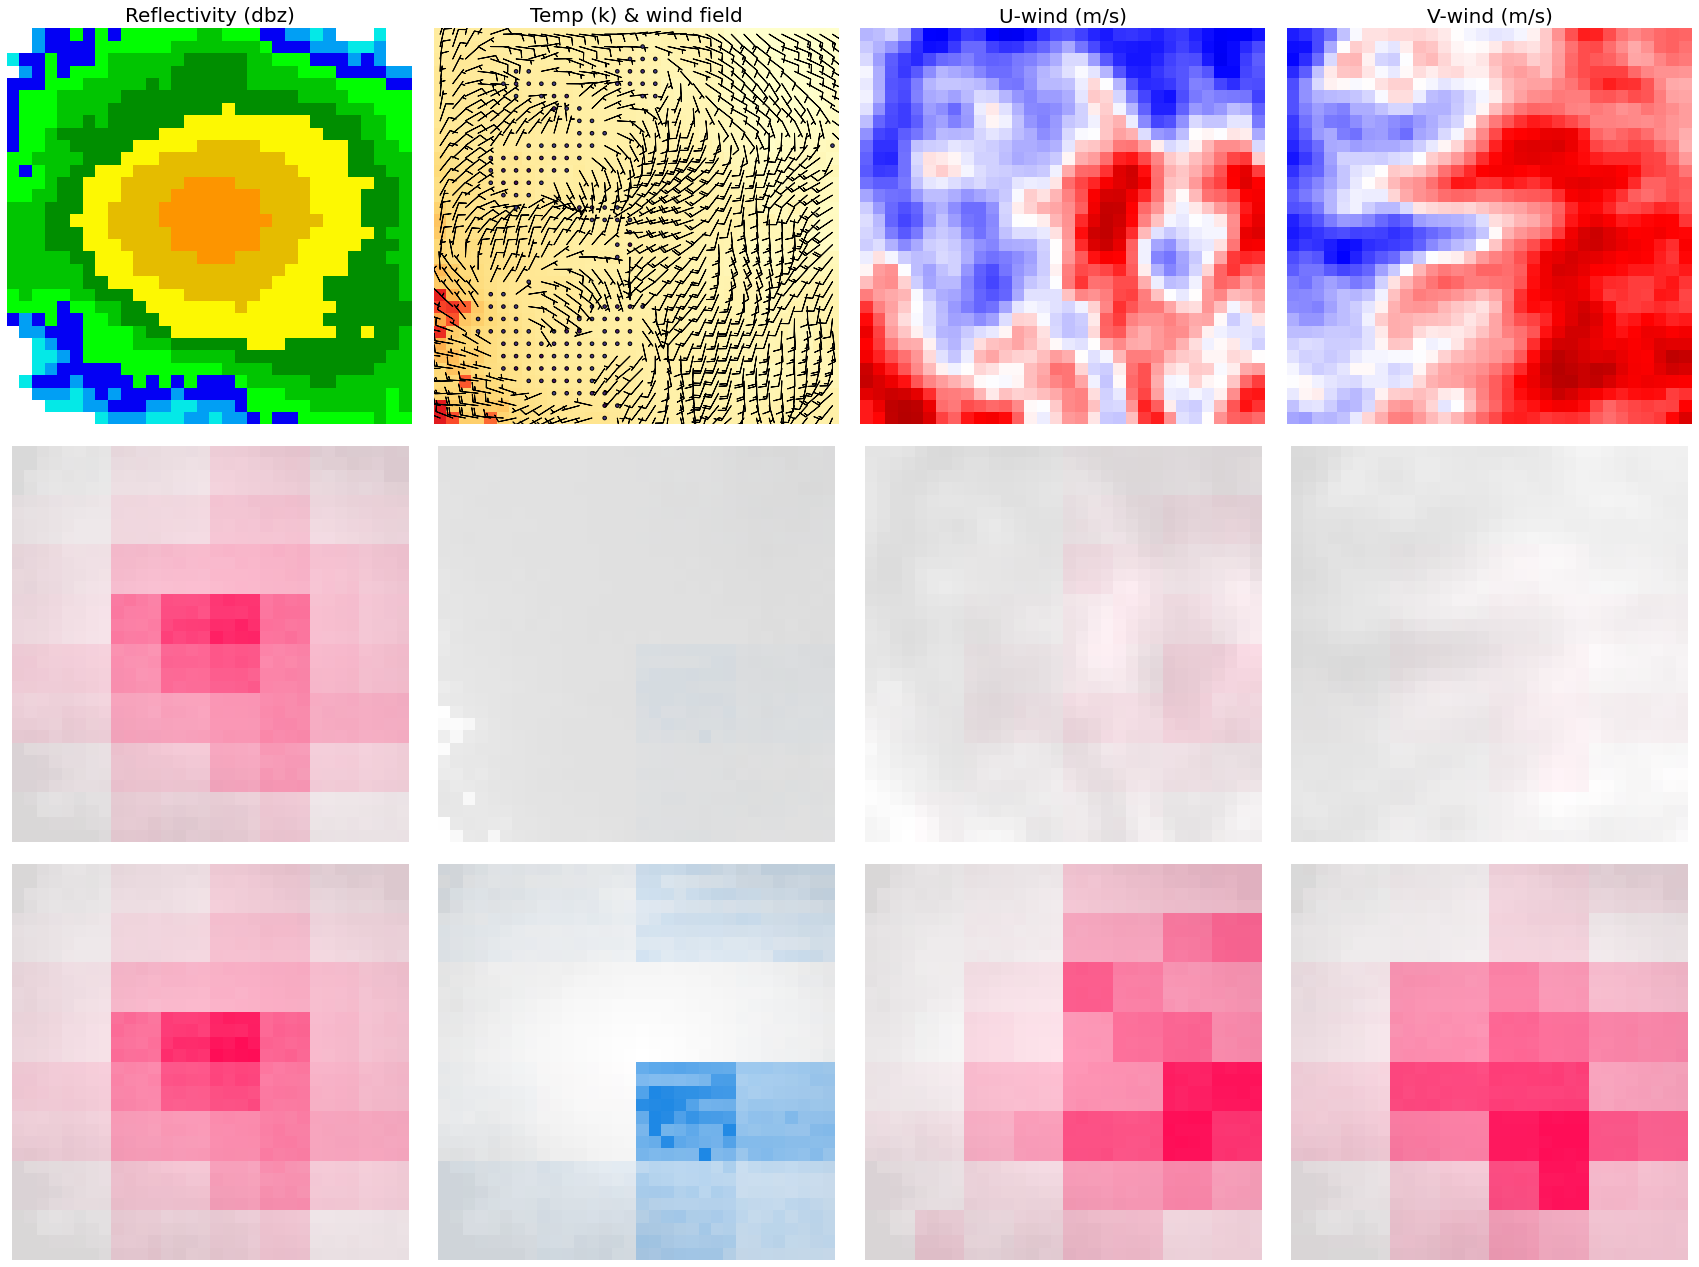

In [ ]:
shap_values_pmm = utils.run_pmm_many_variables(shap_values.values)
plot_storm_shap_batch(np.expand_dims(pmm_best_correct_null_matrix_denorm, axis=0), 
                      np.expand_dims(shap_values_pmm, axis=0))

##### Masker: blur kernel = (32, 32)

In [ ]:
# Evaluate 
shap_values = explain_multiband(X, masker_blur_32x32)
# Plot first 5 samples
plot_storm_shap_batch(Xplot[0:5], shap_values[0:5].values)

**Probability-matched mean case**

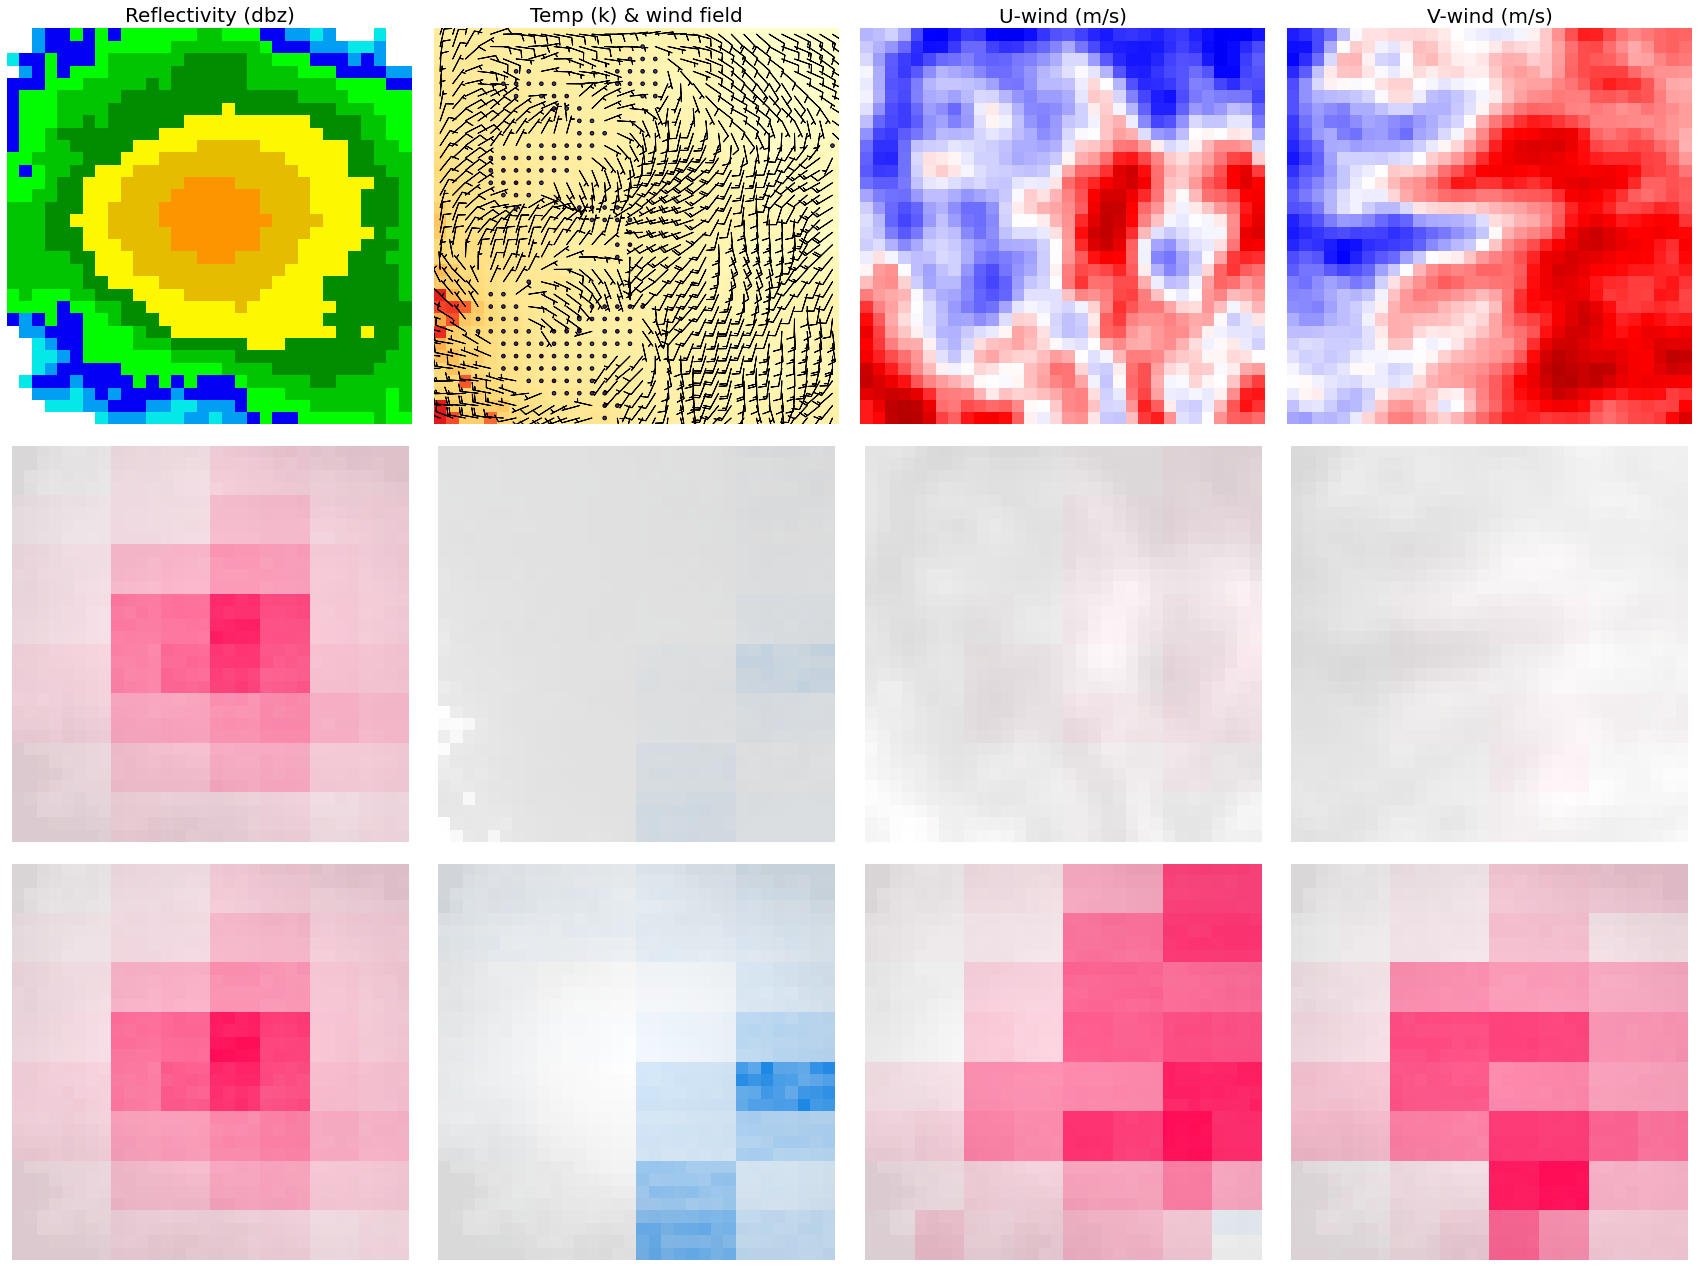

In [ ]:
shap_values_pmm = utils.run_pmm_many_variables(shap_values.values)
plot_storm_shap_batch(np.expand_dims(pmm_best_correct_null_matrix_denorm, axis=0), 
                      np.expand_dims(shap_values_pmm, axis=0))